In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import confusion_matrix
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import os
import time

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import KFold,GroupKFold,StratifiedKFold
import copy
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve ,precision_recall_curve,log_loss,average_precision_score
from sklearn.metrics import f1_score
import random
import gc

%matplotlib inline

In [2]:
#df = reduce_mem_usage(pd.read_csv('/content/drive/My Drive/fraudremove/train.csv'))
#df_test = reduce_mem_usage(pd.read_csv('/content/drive/My Drive/fraudremove/test.csv'))
df_sortprob = pd.read_csv('df_sortprob_23_no_test.csv')
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
def show_cor(df1):
    plt.figure(figsize = (20,20))
    df_corr = df1.corr()
    sns.heatmap(df_corr,fmt = '0.2f',annot = True,xticklabels=df_corr.columns,yticklabels=df_corr.columns,cmap="Reds")
    plt.show()

In [4]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')       
        print("'"+nm+"'",', ',end='')

In [5]:
# LABEL ENCODE
def encode_LE(cat_cols,train,test):
    for col in cat_cols:
        if col in train.columns:
            le = LabelEncoder()
            le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
            train[col] = le.transform(list(train[col].astype(str).values))
            test[col] = le.transform(list(test[col].astype(str).values))      

In [6]:
def group_ag(main_columns, uids, train_df, test_df, aggregations=['mean'],
              fillna = True):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'__'+col+'_'+agg_type
                #拼接训练集和测试集
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])  
                #求AGG
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(columns={agg_type: new_col_name})
                # 取出目标列作为索引
                temp_df.index = list(temp_df[col])
                # 生成map对应的字典
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-100,inplace=True)
                    test_df[new_col_name].fillna(-100,inplace=True)  
                    
                print("'"+new_col_name+"'",', ',end='')
#group_ag(['conam'],['cano'],df,df_test,['mean','std'])
#df['conam_cano_std'].value_counts()

In [7]:
def fillna(df1,df2,col):
    df1[col] = df1[col].map( {'Y': 1, 'N': 0} )
    df2[col] = df2[col].map( {'Y': 1, 'N': 0} )
    df1[col]=df1[col].fillna(-100)
    df2[col]=df2[col].fillna(-100)     
    print(df1[col].value_counts(dropna=False, normalize=True).head())     

In [8]:
def fillNY(df1,df2,col):
    df1[col] = df1[col].map( {'Y': 1, 'N': 0} )
    df2[col] = df2[col].map( {'Y': 1, 'N': 0} )   
    print(df1[col].value_counts(dropna=False, normalize=True).head())      

In [9]:
# COMBINE FEATURES
def encode_CB(col1,col2,df1,df2):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    le = LabelEncoder()
    le.fit(list(df[nm].astype(str).values) + list(df_test[nm].astype(str).values))
    df[nm] = le.transform(list(df[nm].astype(str).values))
    df_test[nm] = le.transform(list(df_test[nm].astype(str).values))
    print(nm,', ',end='')

In [10]:
big_top_value_cols = [col for col in df.columns if df[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols.remove('fraud_ind')
big_top_value_cols.remove('stscd')
#big_top_value_cols.remove('iterm')
#big_top_value_cols.remove('hcefg')
#big_top_value_cols.remove('contp')
big_top_value_cols

['contp', 'flbmk', 'flg_3dsmk', 'hcefg', 'insfg', 'iterm', 'ovrlt']

In [11]:
#not use label encoding
fillNY(df,df_test,'insfg')
fillNY(df,df_test,'ovrlt')
fillNY(df,df_test,'ecfg')
fillna(df,df_test,'flbmk')
fillna(df,df_test,'flg_3dsmk')

0    0.972196
1    0.027804
Name: insfg, dtype: float64
0    0.986693
1    0.013307
Name: ovrlt, dtype: float64
0    0.745513
1    0.254487
Name: ecfg, dtype: float64
 0.0      0.988399
-100.0    0.008267
 1.0      0.003334
Name: flbmk, dtype: float64
 0.0      0.949454
 1.0      0.042279
-100.0    0.008267
Name: flg_3dsmk, dtype: float64


In [12]:
def change_time(data):
    time = data['loctm']
    hour = []
    hour_min = []
    minute = []
    second = []
    for i in time:        
        h = int(i/10000)
        h_m=int(i/100)
        m = int(i%10000/100)
        s = int(i%100)
        hour.append(h)
        hour_min.append(h_m)
        minute.append(m)
        second.append(s)
    data['loctm_hour'] = hour
    data['loctm_min'] = minute
    data['loctm_s'] = second
    data['loctm_hour_min'] = hour_min

In [13]:
def money_process(data):
    log =[]
    sqrt =[]
    for i in data['conam']:
        if(i==0):
            sqrt.append(i)
            log.append(i) 
        else:
            l = np.log(i)
            s = np.sqrt(i)
            sqrt.append(s)
            log.append(l)
    #data['conam_log'] = log
    data['conam_sqrt'] = sqrt  
#money_process(df)
#money_process(df_test)
#print(df['conam_log'].head())

In [14]:
change_time(df_sortprob)
change_time(df)
change_time(df_test)
import copy
df_sortprob=df_sortprob.drop(big_top_value_cols, axis=1)
df=df.drop(big_top_value_cols, axis=1)
df_test=df_test.drop(big_top_value_cols, axis=1)
df_backup = copy.copy(df_sortprob)
df_test_backup = copy.copy(df_test)
print(df.columns)
print(df.shape)

Index(['acqic', 'bacno', 'cano', 'conam', 'csmcu', 'ecfg', 'etymd',
       'fraud_ind', 'locdt', 'loctm', 'mcc', 'mchno', 'scity', 'stocn',
       'stscd', 'txkey', 'loctm_hour', 'loctm_min', 'loctm_s',
       'loctm_hour_min'],
      dtype='object')
(1521787, 20)


In [15]:
# PR 曲线对比
def show_pr():
        l_pr,l_re,l_t = precision_recall_curve(y_valid_df,last_pred)
        pr,re,t = precision_recall_curve(y_valid_df,pred)
        plt.figure(figsize=(8,8))
        plt.plot(l_pr,l_re,color='red',label='last best')
        plt.plot(pr,re,color='green',label="now")
        plt.legend()
        plt.show()

## 從這裡開始

In [16]:
df = copy.copy(df_backup)
df_test = copy.copy(df_test_backup)
print(df.shape[1])
print(df_test.shape[1])
print(df.columns)
print(df_test.columns)

20
19
Index(['acqic', 'bacno', 'cano', 'conam', 'csmcu', 'ecfg', 'etymd',
       'fraud_ind', 'locdt', 'loctm', 'mcc', 'mchno', 'scity', 'stocn',
       'stscd', 'txkey', 'loctm_hour', 'loctm_min', 'loctm_s',
       'loctm_hour_min'],
      dtype='object')
Index(['acqic', 'bacno', 'cano', 'conam', 'csmcu', 'ecfg', 'etymd', 'locdt',
       'loctm', 'mcc', 'mchno', 'scity', 'stocn', 'stscd', 'txkey',
       'loctm_hour', 'loctm_min', 'loctm_s', 'loctm_hour_min'],
      dtype='object')


In [17]:
change_time(df)
change_time(df_test)

In [18]:
#新特徵
encode_CB('bacno','cano',df,df_test) 
encode_CB('mcc','mchno',df,df_test)
encode_CB('stocn','scity',df,df_test)
encode_CB('stscd','csmcu',df,df_test)
encode_CB('cano','mcc_mchno',df,df_test)



bacno_cano , mcc_mchno , stocn_scity , stscd_csmcu , cano_mcc_mchno , 

In [19]:
cano_col=['acqic', 'conam', 'csmcu', 'ecfg', 'etymd',
        'locdt', 'loctm', 'mcc', 'mchno', 'scity', 'stocn',
       'stscd',  'loctm_hour', 'loctm_min', 'loctm_s']
for col in cano_col:
    encode_CB('cano',col,df,df_test)

cano_acqic , cano_conam , cano_csmcu , cano_ecfg , cano_etymd , cano_locdt , cano_loctm , cano_mcc , cano_mchno , cano_scity , cano_stocn , cano_stscd , cano_loctm_hour , cano_loctm_min , cano_loctm_s , 

In [20]:
count_features =['cano_locdt']   
encode_FE(df,df_test,count_features)
cf2 = ['cano_locdt_FE']

'cano_locdt_FE' , 

In [21]:
count_features =['acqic', 'bacno', 'cano', 'conam',  'csmcu', 'ecfg', 'etymd',
         'mcc', 'mchno',
       'scity', 'stocn', 'stscd',  'loctm_hour', 'stocn_scity','mcc_mchno']   
encode_FE(df,df_test,count_features)
count_f =  [ 'acqic_FE' , 'bacno_FE' , 'cano_FE'  , 'csmcu_FE'
      , 'scity_FE'   , 
       'loctm_hour_FE' , 'mcc_mchno_FE' , ]

'acqic_FE' , 'bacno_FE' , 'cano_FE' , 'conam_FE' , 'csmcu_FE' , 'ecfg_FE' , 'etymd_FE' , 'mcc_FE' , 'mchno_FE' , 'scity_FE' , 'stocn_FE' , 'stscd_FE' , 'loctm_hour_FE' , 'stocn_scity_FE' , 'mcc_mchno_FE' , 

In [22]:
col1s =['acqic', 'conam',  'csmcu', 'ecfg', 'etymd',
         'mcc', 'mchno',
       'scity', 'stocn', 'stscd',  'loctm_hour', 'stocn_scity','mcc_mchno']
for col in col1s:      
    group_ag([col],['cano'],df,df_test,['mean','std'])  


'acqic__cano_mean' , 'acqic__cano_std' , 'conam__cano_mean' , 'conam__cano_std' , 'csmcu__cano_mean' , 'csmcu__cano_std' , 'ecfg__cano_mean' , 'ecfg__cano_std' , 'etymd__cano_mean' , 'etymd__cano_std' , 'mcc__cano_mean' , 'mcc__cano_std' , 'mchno__cano_mean' , 'mchno__cano_std' , 'scity__cano_mean' , 'scity__cano_std' , 'stocn__cano_mean' , 'stocn__cano_std' , 'stscd__cano_mean' , 'stscd__cano_std' , 'loctm_hour__cano_mean' , 'loctm_hour__cano_std' , 'stocn_scity__cano_mean' , 'stocn_scity__cano_std' , 'mcc_mchno__cano_mean' , 'mcc_mchno__cano_std' , 

In [23]:
gf_cano =['acqic__cano_mean' , 'acqic__cano_std' , 'conam__cano_mean' , 'conam__cano_std' , 'csmcu__cano_mean' , 'csmcu__cano_std' , 'ecfg__cano_mean' , 'ecfg__cano_std' , 'etymd__cano_mean' , 'etymd__cano_std' , 'mcc__cano_mean' , 'mcc__cano_std' , 'mchno__cano_mean' , 'mchno__cano_std' , 'scity__cano_mean' , 'scity__cano_std' , 'stocn__cano_mean' , 'stocn__cano_std' , 'stscd__cano_mean' , 'stscd__cano_std' , 'loctm_hour__cano_mean' , 'loctm_hour__cano_std' , 'stocn_scity__cano_mean' , 'stocn_scity__cano_std' , 'mcc_mchno__cano_mean' , 'mcc_mchno__cano_std' , ]
re_gf =['etymd__cano_std' ,'stscd__cano_std'  ]
gf_cano = set(gf_cano) -set(re_gf)

In [24]:
re_num_2 =['ecfg']
new = set(col1s)-set(re_num_2)
for col in list(new):      
    group_ag([col],['cano_mcc'],df,df_test,['mean','std']) 
for col in list(new):      
    group_ag([col],['cano_locdt'],df,df_test,['mean','std']) 

'stocn_scity__cano_mcc_mean' , 'stocn_scity__cano_mcc_std' , 'etymd__cano_mcc_mean' , 'etymd__cano_mcc_std' , 'stscd__cano_mcc_mean' , 'stscd__cano_mcc_std' , 'loctm_hour__cano_mcc_mean' , 'loctm_hour__cano_mcc_std' , 'conam__cano_mcc_mean' , 'conam__cano_mcc_std' , 'mcc_mchno__cano_mcc_mean' , 'mcc_mchno__cano_mcc_std' , 'mchno__cano_mcc_mean' , 'mchno__cano_mcc_std' , 'scity__cano_mcc_mean' , 'scity__cano_mcc_std' , 'acqic__cano_mcc_mean' , 'acqic__cano_mcc_std' , 'mcc__cano_mcc_mean' , 'mcc__cano_mcc_std' , 'csmcu__cano_mcc_mean' , 'csmcu__cano_mcc_std' , 'stocn__cano_mcc_mean' , 'stocn__cano_mcc_std' , 'stocn_scity__cano_locdt_mean' , 'stocn_scity__cano_locdt_std' , 'etymd__cano_locdt_mean' , 'etymd__cano_locdt_std' , 'stscd__cano_locdt_mean' , 'stscd__cano_locdt_std' , 'loctm_hour__cano_locdt_mean' , 'loctm_hour__cano_locdt_std' , 'conam__cano_locdt_mean' , 'conam__cano_locdt_std' , 'mcc_mchno__cano_locdt_mean' , 'mcc_mchno__cano_locdt_std' , 'mchno__cano_locdt_mean' , 'mchno__can

In [25]:
gf_cano_mcc=[ 'loctm_hour__cano_mcc_mean' , 'loctm_hour__cano_mcc_std' , 'stocn__cano_mcc_mean' , 'stocn__cano_mcc_std' , 'stscd__cano_mcc_mean' , 'stscd__cano_mcc_std' , 'scity__cano_mcc_mean' , 'scity__cano_mcc_std' , 'conam__cano_mcc_mean' , 'conam__cano_mcc_std' ,  ]

In [26]:
gf_cano_locdt=['etymd__cano_locdt_mean' , 'etymd__cano_locdt_std' , 'loctm_hour__cano_locdt_mean' , 'loctm_hour__cano_locdt_std' , 'stocn__cano_locdt_mean' , 'stocn__cano_locdt_std' , 'mcc_mchno__cano_locdt_mean' , 'mcc_mchno__cano_locdt_std' , 'mcc__cano_locdt_mean' , 'mcc__cano_locdt_std' , 'acqic__cano_locdt_mean' , 'acqic__cano_locdt_std' , 'csmcu__cano_locdt_mean' , 'csmcu__cano_locdt_std' , 'stocn_scity__cano_locdt_mean' , 'stocn_scity__cano_locdt_std' , 'stscd__cano_locdt_mean' , 'stscd__cano_locdt_std' , 'scity__cano_locdt_mean' , 'scity__cano_locdt_std' , 'conam__cano_locdt_mean' , 'conam__cano_locdt_std' , 'mchno__cano_locdt_mean' , 'mchno__cano_locdt_std' ,  ]

In [27]:
model1_features =['acqic', 'conam',  'csmcu', 'ecfg', 'etymd',
       'mcc', 'mchno', 'scity', 'stocn',
       'stscd', 'loctm_hour','stocn_scity','mcc_mchno' ]
#remove_f = ['contp','iterm','hcefg']
temp = model1_features+count_f+cf2+list(gf_cano)+list(gf_cano_locdt)+list(gf_cano_mcc)#+list(gf_test)
model1_features= list(temp.copy())
model1_features.sort()
X_train = df[model1_features]
Y_train = df['fraud_ind']
X_test = df_test[model1_features]
#print(model1_features)
print(X_train.shape[1])
print(X_train.columns)
#show_cor(df[model1_features])

79
Index(['acqic', 'acqic_FE', 'acqic__cano_locdt_mean', 'acqic__cano_locdt_std',
       'acqic__cano_mean', 'acqic__cano_std', 'bacno_FE', 'cano_FE',
       'cano_locdt_FE', 'conam', 'conam__cano_locdt_mean',
       'conam__cano_locdt_std', 'conam__cano_mcc_mean', 'conam__cano_mcc_std',
       'conam__cano_mean', 'conam__cano_std', 'csmcu', 'csmcu_FE',
       'csmcu__cano_locdt_mean', 'csmcu__cano_locdt_std', 'csmcu__cano_mean',
       'csmcu__cano_std', 'ecfg', 'ecfg__cano_mean', 'ecfg__cano_std', 'etymd',
       'etymd__cano_locdt_mean', 'etymd__cano_locdt_std', 'etymd__cano_mean',
       'loctm_hour', 'loctm_hour_FE', 'loctm_hour__cano_locdt_mean',
       'loctm_hour__cano_locdt_std', 'loctm_hour__cano_mcc_mean',
       'loctm_hour__cano_mcc_std', 'loctm_hour__cano_mean',
       'loctm_hour__cano_std', 'mcc', 'mcc__cano_locdt_mean',
       'mcc__cano_locdt_std', 'mcc__cano_mean', 'mcc__cano_std', 'mcc_mchno',
       'mcc_mchno_FE', 'mcc_mchno__cano_locdt_mean',
       'mcc_mchno__c

In [30]:
seed=42
lgb_params = {'num_leaves': 499,
          'min_child_weight': 0.009009297771374483,
          'feature_fraction': 0.8931730501715401,
          'bagging_fraction': 0.8249551970384116,#subsample
          'min_data_in_leaf': 120,
          'objective': 'binary',
          'max_depth': 47,
          'learning_rate': 0.1,         
          "bagging_seed": 11,
          "metric": 'auc',        
          'reg_alpha': 1.1690935357787136, #lambda_l1 
          'reg_lambda': 1.119698800271026,  #lambda_l2
          'n_jobs':12, #num_threads 
          'device': 'cpu',
          'gpu_platform_id': 1,
          'gpu_device_id': 4,
          'seed': seed,         
          #'cat_smooth '   
          'is_unbalance': True,
          'gpu_use_dp' : True
          #'scale_pos_weight':79.8717361224713
         }


In [36]:
seed=42
lgb_params_2 = {'num_leaves': 499,
          'min_child_weight': 7.580352257554229,
          'feature_fraction': 0.9493868722989898,
          'bagging_fraction': 0.8249551970384116,#subsample
          'min_data_in_leaf': 120,
          'objective': 'binary',
          'max_depth': 47,
          'learning_rate': 0.1,         
          "bagging_seed": 11,
          "metric": 'auc',        
          'reg_alpha': 1.1777712961671483, #lambda_l1 
          'reg_lambda': 0.8164215582564447,  #lambda_l2
          'n_jobs':12, #num_threads 
          'device': 'cpu',
          'gpu_platform_id': 1,
          'gpu_device_id': 4,
          'seed': seed,         
          #'cat_smooth '   
          'is_unbalance': True,
          'gpu_use_dp' : True
          #'scale_pos_weight':79.8717361224713
         }

In [37]:
xgb_params = {'max_depth': 47,                      
              'learning_rate':0.02,              
              'colsample_bytree':0.4,
              'subsample':0.8,             
              'scale_pos_weight':73.76231884057971,
              'max_delta_step ':0,
              #'eta': 0.1,
              'missing' : -100,
              'objective' :'binary:logistic',
               # USE CPU
               #'nthread' :1,
              #tree_method='hist'
               # USE GPU
              'gpu_id':'4',
              'tree_method':'gpu_hist',
              'eval_metric': 'logloss',
            'gamma': 0.15626466439591735,
            'min_child_weight':1.5233399970515784, 
            'reg_alpha':4.989195734088519,
            'reg_lambda':4.292050649851185,
             'seed':seed,          
             }

In [38]:
xgb_params_2 = {'max_depth': 47,                      
              'learning_rate':0.02,              
              'colsample_bytree':0.7059116281776322,
              'subsample':0.6136160376363944,             
              'scale_pos_weight':73.76231884057971,
              'max_delta_step ':0,
              #'eta': 0.1,
              'missing' : -100,
              'objective' :'binary:logistic',
               # USE CPU
               #'nthread' :1,
              #tree_method='hist'
               # USE GPU
              'gpu_id':'4',
              'tree_method':'gpu_hist',
              'eval_metric': 'logloss',
            'gamma': 0.40069320193725366,
            'min_child_weight':1.4846766672564873, 
            'reg_alpha': 2.4055125187194095,
            'reg_lambda':2.9307957288073614,
             'seed':seed,          
             }

In [39]:
def get_stacking(x_train, y_train, x_test, n_folds=3,which_model=1,SEED=42,group=1):
    """
    这个函数是stacking的核心，使用交叉验证的方法得到次级训练集
    x_train, y_train, x_test 的值应该为numpy里面的数组类型 numpy.ndarray .
    如果输入为pandas的DataFrame类型则会把报错"""
    train_num, test_num = x_train.shape[0], x_test.shape[0]
    second_level_train_set = np.zeros((train_num,))
    second_level_test_set = np.zeros((test_num,))
    test_nfolds_sets = np.zeros((test_num, n_folds))
    if(group==1):
        folds = GroupKFold(n_splits=n_folds)
        split_groups = df['locdt'] #group
    elif(group ==2):
        folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=SEED)
        split_groups = df['fraud_ind'] #startifiedkfold
    elif(group==3):
        folds = GroupKFold(n_splits=n_folds)
        split_groups = df['bacno'] #group
    elif(group==4):
        folds = GroupKFold(n_splits=n_folds)
        split_groups = df['cano'] #group
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, Y_train,groups=split_groups)): #groupkfold and startifiedfold
        print('_'*100)    
        print("Fold {}".format(fold_))
        
        
        
        train_df, y_train_df = X_train.iloc[trn_idx], Y_train.iloc[trn_idx]
        valid_df, y_valid_df = X_train.iloc[val_idx], Y_train.iloc[val_idx]
        if(which_model==1):
            seed = SEED
            np.random.seed(seed)
            random.seed(seed)
            trn_data = lgb.Dataset(train_df, label=y_train_df)
            val_data = lgb.Dataset(valid_df, label=y_valid_df)
            clf=lgb.train(lgb_params_2,
                        trn_data,
                        num_boost_round= 20000,
                        valid_sets = [trn_data, val_data],
                        # categorical_feature=cat_cols,
                        verbose_eval=100,
                        early_stopping_rounds =200 )
            second_level_train_set[val_idx] = clf.predict(valid_df)           
            test_nfolds_sets[:,fold_] = clf.predict(x_test)   
            
        elif(which_model==2):            
            seed = SEED
            np.random.seed(seed)
            random.seed(seed)
            trn_data = xgb.DMatrix(train_df, label=y_train_df)
            val_data = xgb.DMatrix(valid_df, label=y_valid_df) 
            Dvalid_df = xgb.DMatrix(valid_df,missing=-100)
            DX_test = xgb.DMatrix(X_test,missing=-100)            
            watchlist = [(trn_data,'train'),(val_data,'val')]
            clf = xgb.train(xgb_params_2,
                    trn_data,
                    num_boost_round= 200000,
                    evals  =watchlist,             
                    verbose_eval=100,
                    early_stopping_rounds = 200)    
            second_level_train_set[val_idx] = clf.predict(Dvalid_df)
            test_nfolds_sets[:,fold_] = clf.predict(DX_test)
            #print(second_level_train_set)
            #print(test_nfolds_sets)
        plt.hist(second_level_train_set[val_idx],bins=100)
        plt.ylim((0,6000))
        plt.title('predict Submission')
        plt.show()
        plt.hist(test_nfolds_sets[:,fold_],bins=100)
        plt.ylim((0,6000))
        plt.title('predict Submission')
        plt.show()
    second_level_test_set[:] = test_nfolds_sets.mean(axis=1)
    return second_level_train_set, second_level_test_set

In [40]:
tStart = time.time()#計時開始 
train_sets = []
test_sets = []
#for clf in [lgb_model, xgb_model]:
#    train_set, test_set = get_stacking(clf, X_train, Y_train, X_test)
#    train_sets.append(train_set)
#    test_sets.append(test_set)

model1_features =['acqic', 'conam',  'csmcu', 'ecfg', 'etymd',
       'mcc', 'mchno', 'scity', 'stocn',
       'stscd', 'loctm_hour','stocn_scity','mcc_mchno' ]
#remove_f = ['contp','iterm','hcefg']
temp = model1_features+count_f+cf2+list(gf_cano)+list(gf_cano_locdt)+list(gf_cano_mcc)
model1_features= list(temp.copy())
model1_features.sort()
X_train = df[model1_features]
Y_train = df['fraud_ind']
X_test = df_test[model1_features]

print(X_train.shape[1])
print(X_train.columns)

seed_num=[42,1121,915,1,43443,527418]
for seed_ in seed_num:
    train_set, test_set = get_stacking(X_train, Y_train, X_test,n_folds=3,which_model=1,SEED=seed_,group=1)
    train_sets.append(train_set)
    test_sets.append(test_set)
    train_set, test_set = get_stacking(X_train, Y_train, X_test,n_folds=3,which_model=1,SEED=seed_,group=2)
    train_sets.append(train_set)
    test_sets.append(test_set)
    train_set, test_set = get_stacking(X_train, Y_train, X_test,n_folds=3,which_model=1,SEED=seed_,group=3)
    train_sets.append(train_set)
    test_sets.append(test_set)
    train_set, test_set = get_stacking(X_train, Y_train, X_test,n_folds=3,which_model=1,SEED=seed_,group=4)
    train_sets.append(train_set)
    test_sets.append(test_set)

##################################################################################


79
Index(['acqic', 'acqic_FE', 'acqic__cano_locdt_mean', 'acqic__cano_locdt_std',
       'acqic__cano_mean', 'acqic__cano_std', 'bacno_FE', 'cano_FE',
       'cano_locdt_FE', 'conam', 'conam__cano_locdt_mean',
       'conam__cano_locdt_std', 'conam__cano_mcc_mean', 'conam__cano_mcc_std',
       'conam__cano_mean', 'conam__cano_std', 'csmcu', 'csmcu_FE',
       'csmcu__cano_locdt_mean', 'csmcu__cano_locdt_std', 'csmcu__cano_mean',
       'csmcu__cano_std', 'ecfg', 'ecfg__cano_mean', 'ecfg__cano_std', 'etymd',
       'etymd__cano_locdt_mean', 'etymd__cano_locdt_std', 'etymd__cano_mean',
       'loctm_hour', 'loctm_hour_FE', 'loctm_hour__cano_locdt_mean',
       'loctm_hour__cano_locdt_std', 'loctm_hour__cano_mcc_mean',
       'loctm_hour__cano_mcc_std', 'loctm_hour__cano_mean',
       'loctm_hour__cano_std', 'mcc', 'mcc__cano_locdt_mean',
       'mcc__cano_locdt_std', 'mcc__cano_mean', 'mcc__cano_std', 'mcc_mchno',
       'mcc_mchno_FE', 'mcc_mchno__cano_locdt_mean',
       'mcc_mchno__c

KeyboardInterrupt: 

In [39]:
cf2 =  [  'cano_locdt_FE'  ]
cf =  [  'bacno_FE' , 'cano_FE'  ,
      'mcc_FE' , 'mchno_FE' , 
      'mcc_mchno_FE' , ]

gf =['acqic__cano_mean' , 'acqic__cano_std' , 'conam__cano_mean' , 'conam__cano_std' , 'csmcu__cano_mean' , 'csmcu__cano_std' , 'ecfg__cano_mean' , 'ecfg__cano_std' , 'etymd__cano_mean' , 'etymd__cano_std' , 'mcc__cano_mean' , 'mcc__cano_std' , 'mchno__cano_mean' , 'mchno__cano_std' , 'scity__cano_mean' , 'scity__cano_std' , 'stocn__cano_mean' , 'stocn__cano_std' , 'stscd__cano_mean' , 'stscd__cano_std' , 'loctm_hour__cano_mean' , 'loctm_hour__cano_std' , 'stocn_scity__cano_mean' , 'stocn_scity__cano_std' , 'mcc_mchno__cano_mean' , 'mcc_mchno__cano_std' , ]
re_gf =[ 'etymd__cano_std', 'stscd__cano_std' , ]
gf = set(gf) -set(re_gf)

gf_mcc=[ 'loctm_hour__cano_mcc_mean' , 'loctm_hour__cano_mcc_std' , 'stocn__cano_mcc_mean' , 'stocn__cano_mcc_std' , 'stscd__cano_mcc_mean' , 'stscd__cano_mcc_std' , 'scity__cano_mcc_mean' , 'scity__cano_mcc_std' , 'conam__cano_mcc_mean' , 'conam__cano_mcc_std' ,  ]

gf2=['csmcu__cano_locdt_mean' , 'csmcu__cano_locdt_std' , 'stscd__cano_locdt_mean' , 'stscd__cano_locdt_std' , 'acqic__cano_locdt_mean' , 'acqic__cano_locdt_std' , 'etymd__cano_locdt_mean' , 'etymd__cano_locdt_std' , 'loctm_hour__cano_locdt_mean' , 'loctm_hour__cano_locdt_std' , 'mcc_mchno__cano_locdt_mean' , 'mcc_mchno__cano_locdt_std' , 'stocn__cano_locdt_mean' , 'stocn__cano_locdt_std' , 'conam__cano_locdt_mean' , 'conam__cano_locdt_std' , 'mcc__cano_locdt_mean' , 'mcc__cano_locdt_std' , 'scity__cano_locdt_mean' , 'scity__cano_locdt_std' , 'stocn_scity__cano_locdt_mean' , 'stocn_scity__cano_locdt_std' , 'mchno__cano_locdt_mean' , 'mchno__cano_locdt_std' , ]

77
Index(['acqic', 'acqic__cano_locdt_mean', 'acqic__cano_locdt_std',
       'acqic__cano_mean', 'acqic__cano_std', 'bacno_FE', 'cano_FE',
       'cano_locdt_FE', 'conam', 'conam__cano_locdt_mean',
       'conam__cano_locdt_std', 'conam__cano_mcc_mean', 'conam__cano_mcc_std',
       'conam__cano_mean', 'conam__cano_std', 'csmcu',
       'csmcu__cano_locdt_mean', 'csmcu__cano_locdt_std', 'csmcu__cano_mean',
       'csmcu__cano_std', 'ecfg', 'ecfg__cano_mean', 'ecfg__cano_std', 'etymd',
       'etymd__cano_locdt_mean', 'etymd__cano_locdt_std', 'etymd__cano_mean',
       'loctm_hour', 'loctm_hour__cano_locdt_mean',
       'loctm_hour__cano_locdt_std', 'loctm_hour__cano_mcc_mean',
       'loctm_hour__cano_mcc_std', 'loctm_hour__cano_mean',
       'loctm_hour__cano_std', 'mcc', 'mcc_FE', 'mcc__cano_locdt_mean',
       'mcc__cano_locdt_std', 'mcc__cano_mean', 'mcc__cano_std', 'mcc_mchno',
       'mcc_mchno_FE', 'mcc_mchno__cano_locdt_mean',
       'mcc_mchno__cano_locdt_std', 'mcc_mchno__can

/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-logloss:0.67441	val-logloss:0.674615
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.088497	val-logloss:0.096758
[200]	train-logloss:0.024492	val-logloss:0.035718
[300]	train-logloss:0.012502	val-logloss:0.025779
[400]	train-logloss:0.008668	val-logloss:0.02335
[500]	train-logloss:0.006818	val-logloss:0.022487
[600]	train-logloss:0.005684	val-logloss:0.0221
[700]	train-logloss:0.004939	val-logloss:0.021954
[800]	train-logloss:0.004413	val-logloss:0.021905
[900]	train-logloss:0.004023	val-logloss:0.021949
[1000]	train-logloss:0.003725	val-logloss:0.022031
Stopping. Best iteration:
[835]	train-logloss:0.004263	val-logloss:0.021896



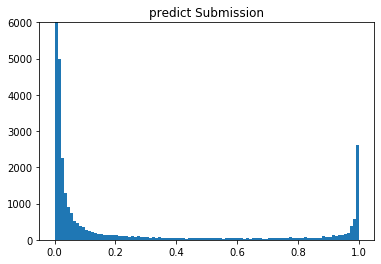

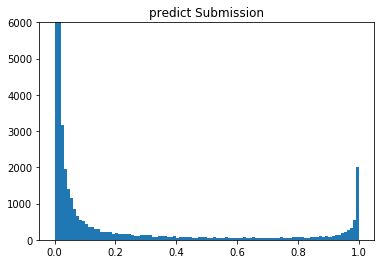

____________________________________________________________________________________________________
Fold 1
[0]	train-logloss:0.674362	val-logloss:0.674529
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.088465	val-logloss:0.096273
[200]	train-logloss:0.024538	val-logloss:0.035884
[300]	train-logloss:0.012539	val-logloss:0.026213
[400]	train-logloss:0.008692	val-logloss:0.023932
[500]	train-logloss:0.006842	val-logloss:0.02311
[600]	train-logloss:0.005726	val-logloss:0.02272
[700]	train-logloss:0.004971	val-logloss:0.022585
[800]	train-logloss:0.004429	val-logloss:0.022587
[900]	train-logloss:0.004034	val-logloss:0.022635
Stopping. Best iteration:
[739]	train-logloss:0.004736	val-logloss:0.022568



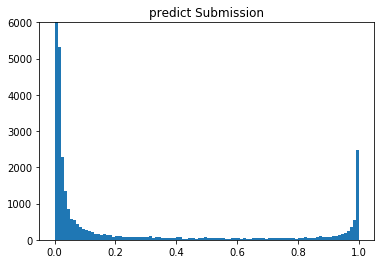

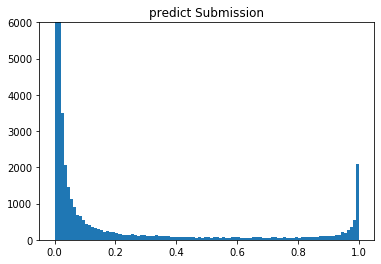

____________________________________________________________________________________________________
Fold 2
[0]	train-logloss:0.674374	val-logloss:0.674539
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.089069	val-logloss:0.096446
[200]	train-logloss:0.024931	val-logloss:0.035549
[300]	train-logloss:0.012832	val-logloss:0.025586
[400]	train-logloss:0.008922	val-logloss:0.023131
[500]	train-logloss:0.007003	val-logloss:0.022204
[600]	train-logloss:0.005851	val-logloss:0.021813
[700]	train-logloss:0.005074	val-logloss:0.021663
[800]	train-logloss:0.004537	val-logloss:0.021611
[900]	train-logloss:0.00412	val-logloss:0.021642
Stopping. Best iteration:
[790]	train-logloss:0.004579	val-logloss:0.021601



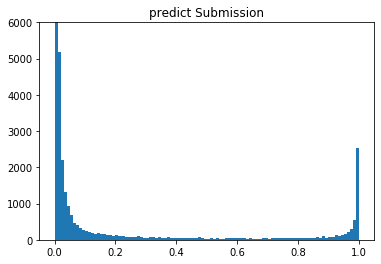

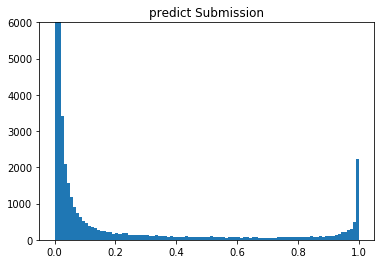

____________________________________________________________________________________________________
Fold 0


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-logloss:0.674453	val-logloss:0.674533
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.08974	val-logloss:0.093487
[200]	train-logloss:0.025477	val-logloss:0.031245
[300]	train-logloss:0.01315	val-logloss:0.020393
[400]	train-logloss:0.009079	val-logloss:0.017321
[500]	train-logloss:0.007058	val-logloss:0.016008
[600]	train-logloss:0.005815	val-logloss:0.015265
[700]	train-logloss:0.004989	val-logloss:0.014849
[800]	train-logloss:0.004421	val-logloss:0.014626
[900]	train-logloss:0.003981	val-logloss:0.01446
[1000]	train-logloss:0.003651	val-logloss:0.014373
[1100]	train-logloss:0.00339	val-logloss:0.014328
[1200]	train-logloss:0.003182	val-logloss:0.01431
[1300]	train-logloss:0.003006	val-logloss:0.014306
[1400]	train-logloss:0.002863	val-logloss:0.014315
Stopping. Best iteration:
[1249]	train-logloss:0.003092	val-logloss:0.014301



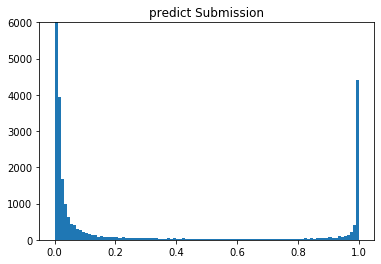

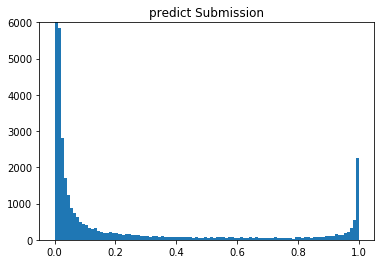

____________________________________________________________________________________________________
Fold 1
[0]	train-logloss:0.674424	val-logloss:0.674533
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.089412	val-logloss:0.094041
[200]	train-logloss:0.025217	val-logloss:0.031856
[300]	train-logloss:0.012917	val-logloss:0.020959
[400]	train-logloss:0.008925	val-logloss:0.017897
[500]	train-logloss:0.006951	val-logloss:0.016577
[600]	train-logloss:0.005746	val-logloss:0.01587
[700]	train-logloss:0.004951	val-logloss:0.015468
[800]	train-logloss:0.004383	val-logloss:0.015233
[900]	train-logloss:0.003961	val-logloss:0.0151
[1000]	train-logloss:0.003632	val-logloss:0.015023
[1100]	train-logloss:0.003373	val-logloss:0.014981
[1200]	train-logloss:0.003159	val-logloss:0.014964
[1300]	train-logloss:0.002983	val-logloss:0.014962
Stopping. Best iteration:
[1188]	train-loglos

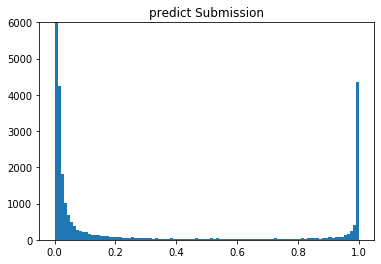

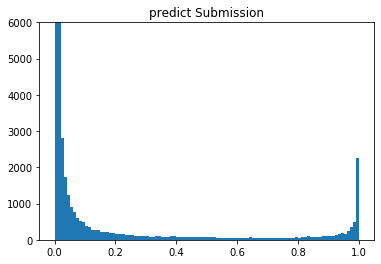

____________________________________________________________________________________________________
Fold 2
[0]	train-logloss:0.674382	val-logloss:0.674473
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.089337	val-logloss:0.093572
[200]	train-logloss:0.025106	val-logloss:0.031558
[300]	train-logloss:0.012832	val-logloss:0.020871
[400]	train-logloss:0.008838	val-logloss:0.017958
[500]	train-logloss:0.006876	val-logloss:0.016718
[600]	train-logloss:0.005659	val-logloss:0.016026
[700]	train-logloss:0.004855	val-logloss:0.015638
[800]	train-logloss:0.004292	val-logloss:0.015412
[900]	train-logloss:0.003867	val-logloss:0.015282
[1000]	train-logloss:0.003544	val-logloss:0.015196
[1100]	train-logloss:0.003288	val-logloss:0.015153
[1200]	train-logloss:0.003079	val-logloss:0.015124
[1300]	train-logloss:0.002907	val-logloss:0.015124
[1400]	train-logloss:0.002762	val-logloss:

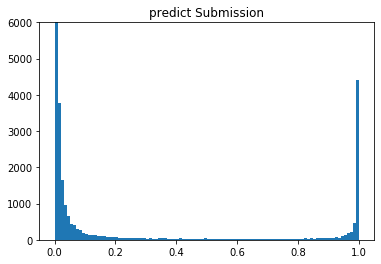

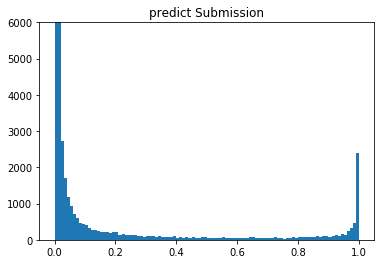

____________________________________________________________________________________________________
Fold 0


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-logloss:0.674362	val-logloss:0.674643
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.087953	val-logloss:0.099699
[200]	train-logloss:0.024345	val-logloss:0.04036
[300]	train-logloss:0.012521	val-logloss:0.031616
[400]	train-logloss:0.008762	val-logloss:0.030072
[500]	train-logloss:0.006932	val-logloss:0.029914
[600]	train-logloss:0.005829	val-logloss:0.029986
Stopping. Best iteration:
[476]	train-logloss:0.007269	val-logloss:0.02989



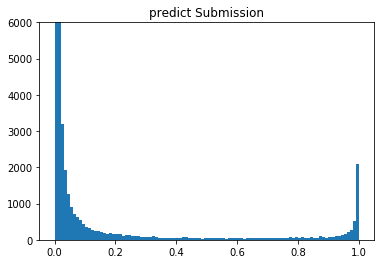

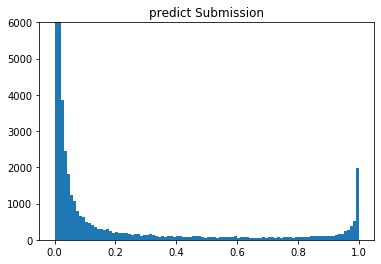

____________________________________________________________________________________________________
Fold 1
[0]	train-logloss:0.674429	val-logloss:0.674662
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.088733	val-logloss:0.098456
[200]	train-logloss:0.024763	val-logloss:0.037799
[300]	train-logloss:0.012745	val-logloss:0.028139
[400]	train-logloss:0.00891	val-logloss:0.025976
[500]	train-logloss:0.007005	val-logloss:0.025276
[600]	train-logloss:0.005886	val-logloss:0.02508
[700]	train-logloss:0.005125	val-logloss:0.02505
[800]	train-logloss:0.004575	val-logloss:0.025139
Stopping. Best iteration:
[693]	train-logloss:0.005174	val-logloss:0.025039



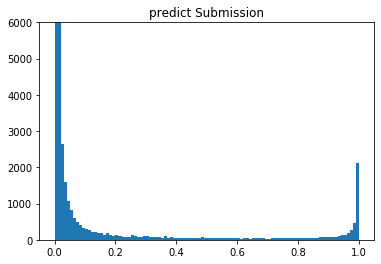

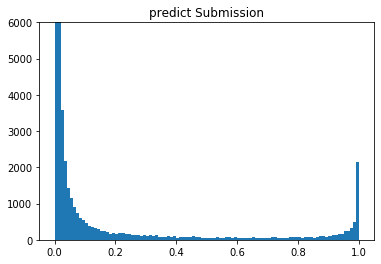

____________________________________________________________________________________________________
Fold 2
[0]	train-logloss:0.674313	val-logloss:0.674581
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.087868	val-logloss:0.099859
[200]	train-logloss:0.024156	val-logloss:0.040876
[300]	train-logloss:0.012243	val-logloss:0.032189
[400]	train-logloss:0.008471	val-logloss:0.030752
[500]	train-logloss:0.006678	val-logloss:0.030614
[600]	train-logloss:0.005598	val-logloss:0.030762
Stopping. Best iteration:
[493]	train-logloss:0.006776	val-logloss:0.030594



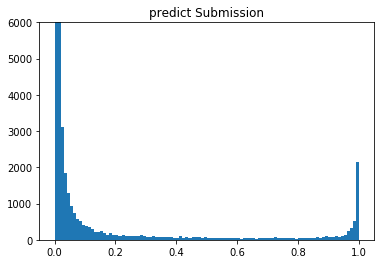

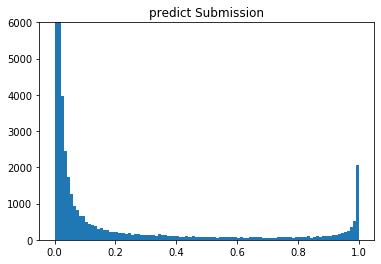

____________________________________________________________________________________________________
Fold 0


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-logloss:0.674362	val-logloss:0.674582
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.088447	val-logloss:0.09853
[200]	train-logloss:0.024722	val-logloss:0.038438
[300]	train-logloss:0.012753	val-logloss:0.029115
[400]	train-logloss:0.008937	val-logloss:0.027107
[500]	train-logloss:0.007066	val-logloss:0.026498
[600]	train-logloss:0.005956	val-logloss:0.026392
[700]	train-logloss:0.005186	val-logloss:0.026481
Stopping. Best iteration:
[585]	train-logloss:0.006094	val-logloss:0.026377



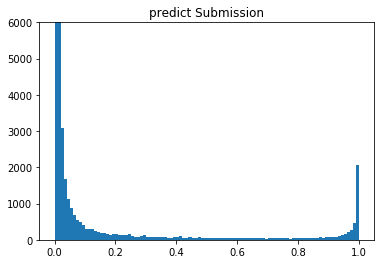

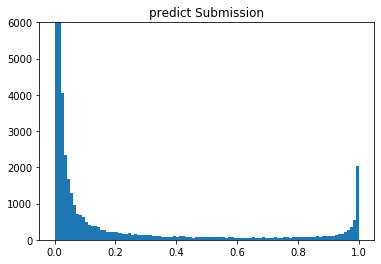

____________________________________________________________________________________________________
Fold 1
[0]	train-logloss:0.674349	val-logloss:0.674642
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.087903	val-logloss:0.100621
[200]	train-logloss:0.024112	val-logloss:0.041076
[300]	train-logloss:0.012289	val-logloss:0.032302
[400]	train-logloss:0.008586	val-logloss:0.030892
[500]	train-logloss:0.006762	val-logloss:0.03068
[600]	train-logloss:0.005671	val-logloss:0.030815
Stopping. Best iteration:
[492]	train-logloss:0.006862	val-logloss:0.030655



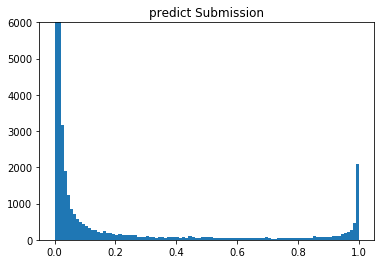

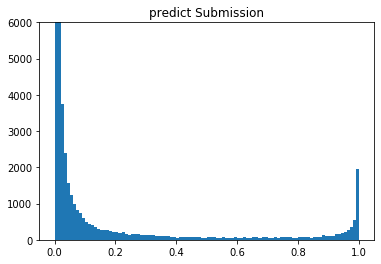

____________________________________________________________________________________________________
Fold 2
[0]	train-logloss:0.674344	val-logloss:0.674614
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.088301	val-logloss:0.098574
[200]	train-logloss:0.024404	val-logloss:0.038807
[300]	train-logloss:0.012466	val-logloss:0.029862
[400]	train-logloss:0.008664	val-logloss:0.028149
[500]	train-logloss:0.00685	val-logloss:0.027846
[600]	train-logloss:0.005741	val-logloss:0.027832
[700]	train-logloss:0.005003	val-logloss:0.028013
Stopping. Best iteration:
[550]	train-logloss:0.006238	val-logloss:0.027787



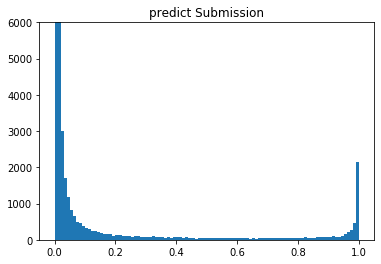

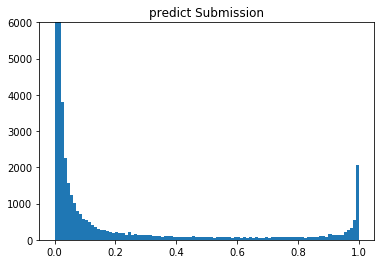

____________________________________________________________________________________________________
Fold 0


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-logloss:0.67441	val-logloss:0.674615
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.088497	val-logloss:0.096758
[200]	train-logloss:0.024492	val-logloss:0.035718
[300]	train-logloss:0.012502	val-logloss:0.025779
[400]	train-logloss:0.008668	val-logloss:0.02335
[500]	train-logloss:0.006818	val-logloss:0.022487
[600]	train-logloss:0.005684	val-logloss:0.0221
[700]	train-logloss:0.004939	val-logloss:0.021954
[800]	train-logloss:0.004413	val-logloss:0.021905
[900]	train-logloss:0.004023	val-logloss:0.021949
[1000]	train-logloss:0.003725	val-logloss:0.022031
Stopping. Best iteration:
[835]	train-logloss:0.004263	val-logloss:0.021896



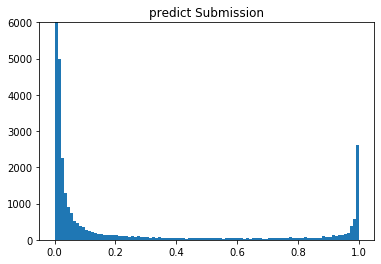

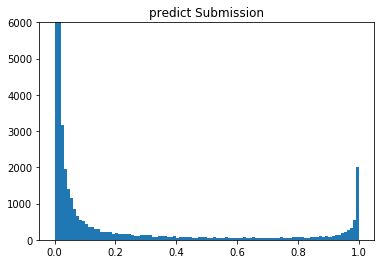

____________________________________________________________________________________________________
Fold 1
[0]	train-logloss:0.674362	val-logloss:0.674529
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.088465	val-logloss:0.096273
[200]	train-logloss:0.024538	val-logloss:0.035884
[300]	train-logloss:0.012539	val-logloss:0.026213
[400]	train-logloss:0.008692	val-logloss:0.023932
[500]	train-logloss:0.006842	val-logloss:0.02311
[600]	train-logloss:0.005726	val-logloss:0.02272
[700]	train-logloss:0.004971	val-logloss:0.022585
[800]	train-logloss:0.004429	val-logloss:0.022587
[900]	train-logloss:0.004034	val-logloss:0.022635
Stopping. Best iteration:
[739]	train-logloss:0.004736	val-logloss:0.022568



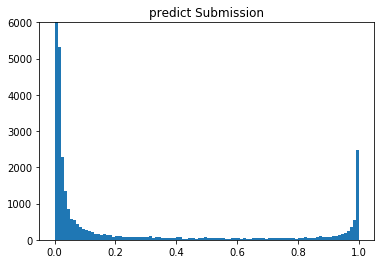

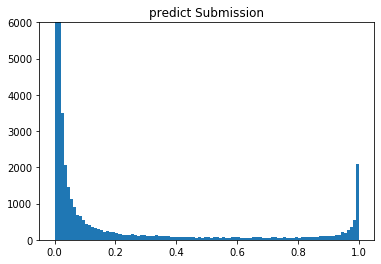

____________________________________________________________________________________________________
Fold 2
[0]	train-logloss:0.674374	val-logloss:0.674539
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.089069	val-logloss:0.096446
[200]	train-logloss:0.024931	val-logloss:0.035549
[300]	train-logloss:0.012832	val-logloss:0.025586
[400]	train-logloss:0.008922	val-logloss:0.023131
[500]	train-logloss:0.007003	val-logloss:0.022204
[600]	train-logloss:0.005851	val-logloss:0.021813
[700]	train-logloss:0.005074	val-logloss:0.021663
[800]	train-logloss:0.004537	val-logloss:0.021611
[900]	train-logloss:0.00412	val-logloss:0.021642
Stopping. Best iteration:
[790]	train-logloss:0.004579	val-logloss:0.021601



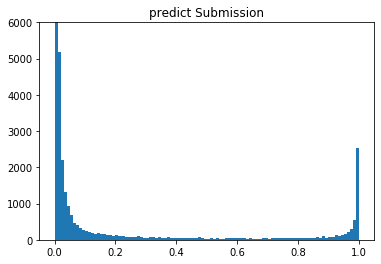

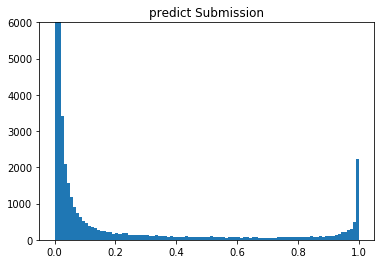

____________________________________________________________________________________________________
Fold 0


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-logloss:0.674387	val-logloss:0.674488
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.089539	val-logloss:0.093798
[200]	train-logloss:0.02538	val-logloss:0.031706
[300]	train-logloss:0.013056	val-logloss:0.02084
[400]	train-logloss:0.008994	val-logloss:0.017751
[500]	train-logloss:0.006999	val-logloss:0.016432
[600]	train-logloss:0.005801	val-logloss:0.015736
[700]	train-logloss:0.005005	val-logloss:0.015325
[800]	train-logloss:0.004437	val-logloss:0.015082
[900]	train-logloss:0.004018	val-logloss:0.014922
[1000]	train-logloss:0.003691	val-logloss:0.01483
[1100]	train-logloss:0.003433	val-logloss:0.014777
[1200]	train-logloss:0.003234	val-logloss:0.014759
[1300]	train-logloss:0.003061	val-logloss:0.014754
[1400]	train-logloss:0.002915	val-logloss:0.014771
Stopping. Best iteration:
[1222]	train-logloss:0.00319	val-logloss:0.014748



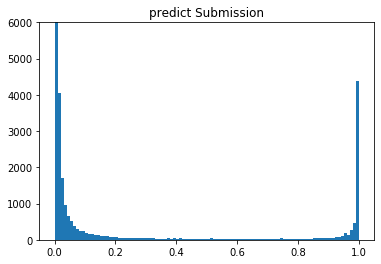

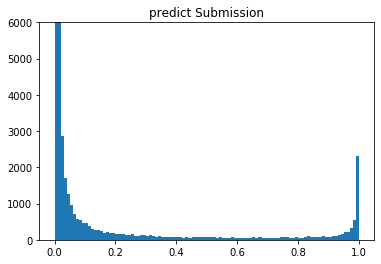

____________________________________________________________________________________________________
Fold 1
[0]	train-logloss:0.67442	val-logloss:0.674501
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.089528	val-logloss:0.093823
[200]	train-logloss:0.02529	val-logloss:0.031599
[300]	train-logloss:0.01302	val-logloss:0.020834
[400]	train-logloss:0.009014	val-logloss:0.017835
[500]	train-logloss:0.007016	val-logloss:0.016529
[600]	train-logloss:0.005783	val-logloss:0.015816
[700]	train-logloss:0.004955	val-logloss:0.015398
[800]	train-logloss:0.004387	val-logloss:0.015158
[900]	train-logloss:0.003948	val-logloss:0.015005
[1000]	train-logloss:0.003627	val-logloss:0.014915
[1100]	train-logloss:0.00336	val-logloss:0.014852
[1200]	train-logloss:0.003152	val-logloss:0.014826
[1300]	train-logloss:0.002971	val-logloss:0.014828
[1400]	train-logloss:0.002829	val-logloss:0.01

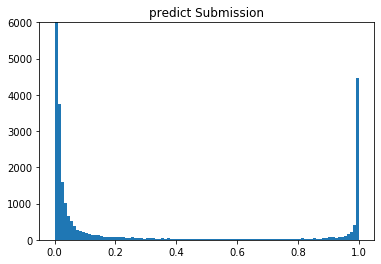

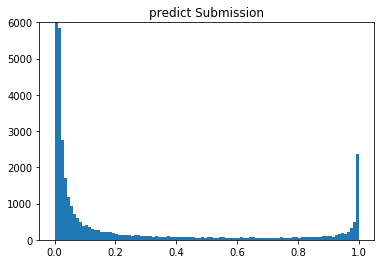

____________________________________________________________________________________________________
Fold 2
[0]	train-logloss:0.674386	val-logloss:0.674471
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.089366	val-logloss:0.093536
[200]	train-logloss:0.025161	val-logloss:0.031395
[300]	train-logloss:0.012904	val-logloss:0.0206
[400]	train-logloss:0.008923	val-logloss:0.017602
[500]	train-logloss:0.006934	val-logloss:0.0163
[600]	train-logloss:0.005731	val-logloss:0.015608
[700]	train-logloss:0.004924	val-logloss:0.015209
[800]	train-logloss:0.004336	val-logloss:0.014968
[900]	train-logloss:0.003914	val-logloss:0.014827
[1000]	train-logloss:0.003577	val-logloss:0.014744
[1100]	train-logloss:0.003319	val-logloss:0.014699
[1200]	train-logloss:0.003109	val-logloss:0.014687
[1300]	train-logloss:0.002936	val-logloss:0.014694
[1400]	train-logloss:0.002797	val-logloss:0.01

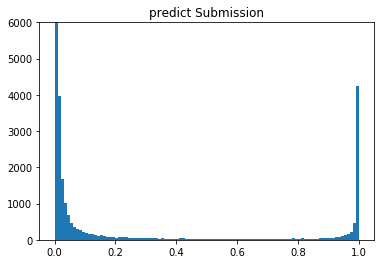

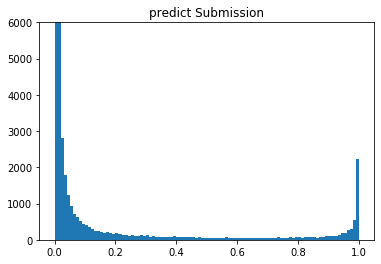

____________________________________________________________________________________________________
Fold 0


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-logloss:0.674362	val-logloss:0.674643
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.087953	val-logloss:0.099699
[200]	train-logloss:0.024345	val-logloss:0.04036
[300]	train-logloss:0.012521	val-logloss:0.031616
[400]	train-logloss:0.008762	val-logloss:0.030072
[500]	train-logloss:0.006932	val-logloss:0.029914
[600]	train-logloss:0.005829	val-logloss:0.029986
Stopping. Best iteration:
[476]	train-logloss:0.007269	val-logloss:0.02989



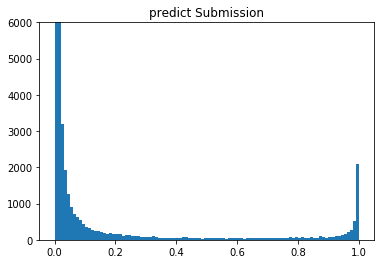

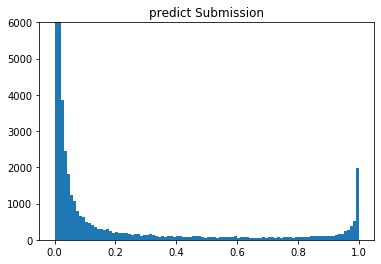

____________________________________________________________________________________________________
Fold 1
[0]	train-logloss:0.674429	val-logloss:0.674662
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.088733	val-logloss:0.098456
[200]	train-logloss:0.024763	val-logloss:0.037799
[300]	train-logloss:0.012745	val-logloss:0.028139
[400]	train-logloss:0.00891	val-logloss:0.025976
[500]	train-logloss:0.007005	val-logloss:0.025276
[600]	train-logloss:0.005886	val-logloss:0.02508
[700]	train-logloss:0.005125	val-logloss:0.02505
[800]	train-logloss:0.004575	val-logloss:0.025139
Stopping. Best iteration:
[693]	train-logloss:0.005174	val-logloss:0.025039



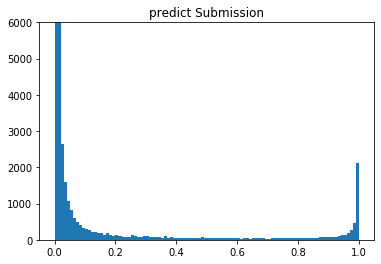

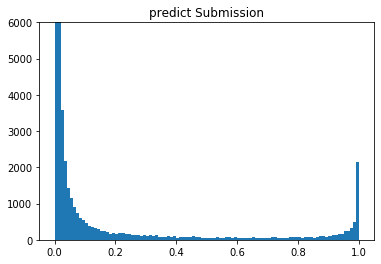

____________________________________________________________________________________________________
Fold 2
[0]	train-logloss:0.674313	val-logloss:0.674581
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.087868	val-logloss:0.099859
[200]	train-logloss:0.024156	val-logloss:0.040876
[300]	train-logloss:0.012243	val-logloss:0.032189
[400]	train-logloss:0.008471	val-logloss:0.030752
[500]	train-logloss:0.006678	val-logloss:0.030614
[600]	train-logloss:0.005598	val-logloss:0.030762
Stopping. Best iteration:
[493]	train-logloss:0.006776	val-logloss:0.030594



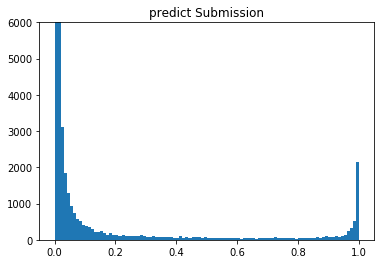

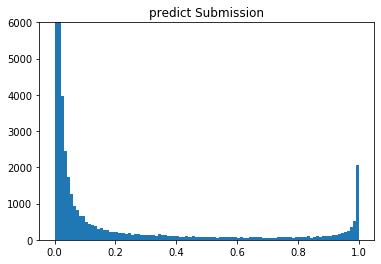

____________________________________________________________________________________________________
Fold 0


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-logloss:0.674362	val-logloss:0.674582
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.088447	val-logloss:0.09853
[200]	train-logloss:0.024722	val-logloss:0.038438
[300]	train-logloss:0.012753	val-logloss:0.029115
[400]	train-logloss:0.008937	val-logloss:0.027107
[500]	train-logloss:0.007066	val-logloss:0.026498
[600]	train-logloss:0.005956	val-logloss:0.026392
[700]	train-logloss:0.005186	val-logloss:0.026481
Stopping. Best iteration:
[585]	train-logloss:0.006094	val-logloss:0.026377



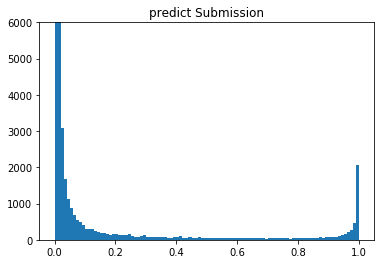

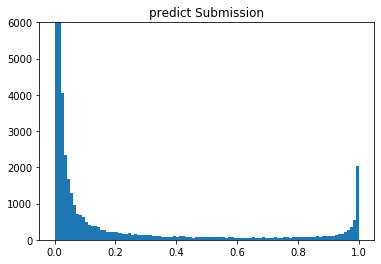

____________________________________________________________________________________________________
Fold 1
[0]	train-logloss:0.674349	val-logloss:0.674642
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.087903	val-logloss:0.100621
[200]	train-logloss:0.024112	val-logloss:0.041076
[300]	train-logloss:0.012289	val-logloss:0.032302
[400]	train-logloss:0.008586	val-logloss:0.030892
[500]	train-logloss:0.006762	val-logloss:0.03068
[600]	train-logloss:0.005671	val-logloss:0.030815
Stopping. Best iteration:
[492]	train-logloss:0.006862	val-logloss:0.030655



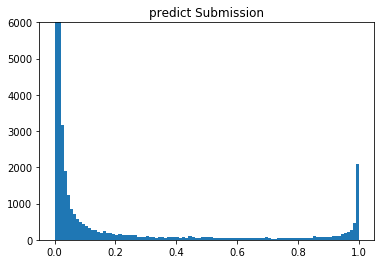

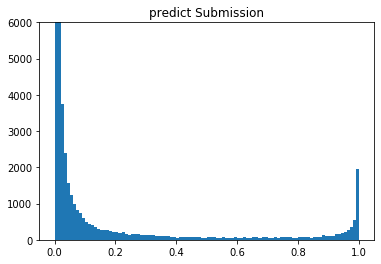

____________________________________________________________________________________________________
Fold 2
[0]	train-logloss:0.674344	val-logloss:0.674614
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.088301	val-logloss:0.098574
[200]	train-logloss:0.024404	val-logloss:0.038807
[300]	train-logloss:0.012466	val-logloss:0.029862
[400]	train-logloss:0.008664	val-logloss:0.028149
[500]	train-logloss:0.00685	val-logloss:0.027846
[600]	train-logloss:0.005741	val-logloss:0.027832
[700]	train-logloss:0.005003	val-logloss:0.028013
Stopping. Best iteration:
[550]	train-logloss:0.006238	val-logloss:0.027787



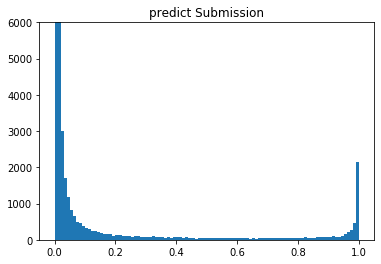

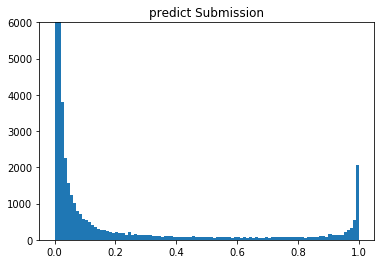

____________________________________________________________________________________________________
Fold 0


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-logloss:0.67441	val-logloss:0.674615
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.088497	val-logloss:0.096758
[200]	train-logloss:0.024492	val-logloss:0.035718
[300]	train-logloss:0.012502	val-logloss:0.025779
[400]	train-logloss:0.008668	val-logloss:0.02335
[500]	train-logloss:0.006818	val-logloss:0.022487
[600]	train-logloss:0.005684	val-logloss:0.0221
[700]	train-logloss:0.004939	val-logloss:0.021954
[800]	train-logloss:0.004413	val-logloss:0.021905
[900]	train-logloss:0.004023	val-logloss:0.021949
[1000]	train-logloss:0.003725	val-logloss:0.022031
Stopping. Best iteration:
[835]	train-logloss:0.004263	val-logloss:0.021896



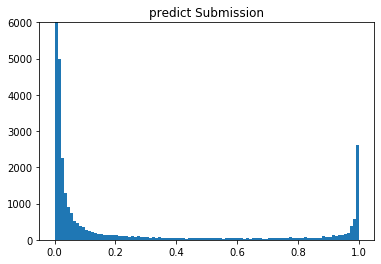

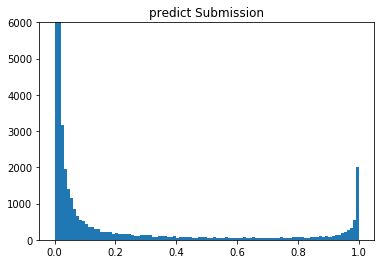

____________________________________________________________________________________________________
Fold 1
[0]	train-logloss:0.674362	val-logloss:0.674529
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.088465	val-logloss:0.096273
[200]	train-logloss:0.024538	val-logloss:0.035884
[300]	train-logloss:0.012539	val-logloss:0.026213
[400]	train-logloss:0.008692	val-logloss:0.023932
[500]	train-logloss:0.006842	val-logloss:0.02311
[600]	train-logloss:0.005726	val-logloss:0.02272
[700]	train-logloss:0.004971	val-logloss:0.022585
[800]	train-logloss:0.004429	val-logloss:0.022587
[900]	train-logloss:0.004034	val-logloss:0.022635
Stopping. Best iteration:
[739]	train-logloss:0.004736	val-logloss:0.022568



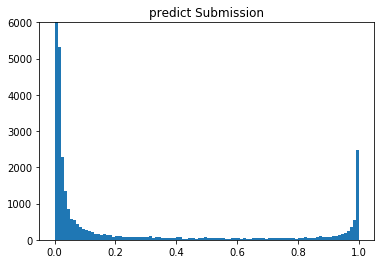

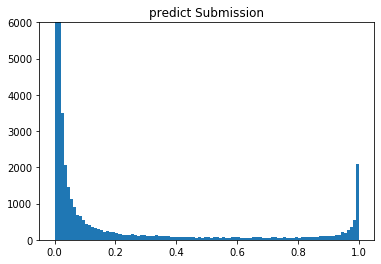

____________________________________________________________________________________________________
Fold 2
[0]	train-logloss:0.674374	val-logloss:0.674539
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.089069	val-logloss:0.096446
[200]	train-logloss:0.024931	val-logloss:0.035549
[300]	train-logloss:0.012832	val-logloss:0.025586
[400]	train-logloss:0.008922	val-logloss:0.023131
[500]	train-logloss:0.007003	val-logloss:0.022204
[600]	train-logloss:0.005851	val-logloss:0.021813
[700]	train-logloss:0.005074	val-logloss:0.021663
[800]	train-logloss:0.004537	val-logloss:0.021611
[900]	train-logloss:0.00412	val-logloss:0.021642
Stopping. Best iteration:
[790]	train-logloss:0.004579	val-logloss:0.021601



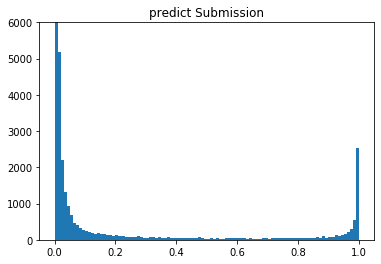

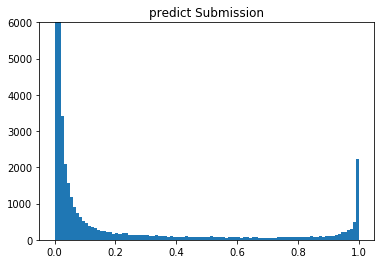

____________________________________________________________________________________________________
Fold 0


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-logloss:0.674409	val-logloss:0.674493
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.089496	val-logloss:0.093732
[200]	train-logloss:0.025261	val-logloss:0.031589
[300]	train-logloss:0.012922	val-logloss:0.020807
[400]	train-logloss:0.008898	val-logloss:0.017838
[500]	train-logloss:0.006895	val-logloss:0.016548
[600]	train-logloss:0.005687	val-logloss:0.015853
[700]	train-logloss:0.004879	val-logloss:0.015467
[800]	train-logloss:0.004313	val-logloss:0.015263
[900]	train-logloss:0.003885	val-logloss:0.015132
[1000]	train-logloss:0.003556	val-logloss:0.015061
[1100]	train-logloss:0.003297	val-logloss:0.015027
[1200]	train-logloss:0.003092	val-logloss:0.015012
[1300]	train-logloss:0.002913	val-logloss:0.015015
[1400]	train-logloss:0.002768	val-logloss:0.01504
Stopping. Best iteration:
[1232]	train-logloss:0.003026	val-logloss:0.015006



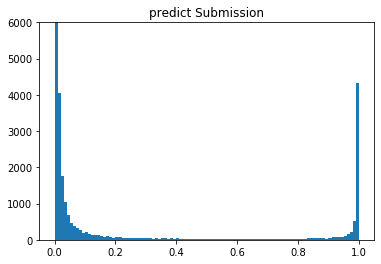

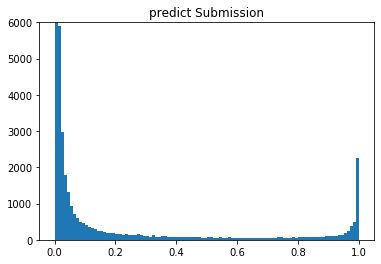

____________________________________________________________________________________________________
Fold 1
[0]	train-logloss:0.674398	val-logloss:0.674491
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.089587	val-logloss:0.093705
[200]	train-logloss:0.025325	val-logloss:0.031494
[300]	train-logloss:0.013078	val-logloss:0.020755
[400]	train-logloss:0.009021	val-logloss:0.017709
[500]	train-logloss:0.007001	val-logloss:0.016381
[600]	train-logloss:0.005788	val-logloss:0.015671
[700]	train-logloss:0.004964	val-logloss:0.015234
[800]	train-logloss:0.004375	val-logloss:0.014975
[900]	train-logloss:0.003952	val-logloss:0.014833
[1000]	train-logloss:0.003616	val-logloss:0.014736
[1100]	train-logloss:0.003354	val-logloss:0.014678
[1200]	train-logloss:0.003147	val-logloss:0.014657
[1300]	train-logloss:0.002974	val-logloss:0.014655
[1400]	train-logloss:0.00283	val-logloss:0

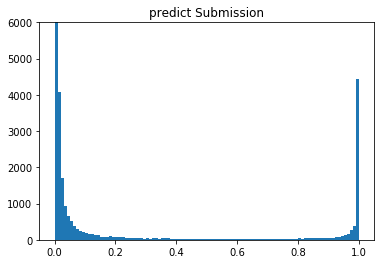

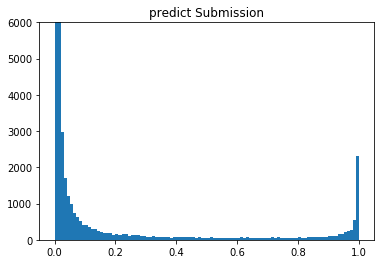

____________________________________________________________________________________________________
Fold 2
[0]	train-logloss:0.67439	val-logloss:0.674497
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.089324	val-logloss:0.093816
[200]	train-logloss:0.02524	val-logloss:0.031772
[300]	train-logloss:0.01298	val-logloss:0.021015
[400]	train-logloss:0.008939	val-logloss:0.018036
[500]	train-logloss:0.006962	val-logloss:0.016764
[600]	train-logloss:0.005756	val-logloss:0.016078
[700]	train-logloss:0.004935	val-logloss:0.015691
[800]	train-logloss:0.004352	val-logloss:0.015465
[900]	train-logloss:0.003921	val-logloss:0.015321
[1000]	train-logloss:0.00359	val-logloss:0.015253
[1100]	train-logloss:0.003326	val-logloss:0.015218
[1200]	train-logloss:0.00311	val-logloss:0.015208
[1300]	train-logloss:0.002943	val-logloss:0.01522
Stopping. Best iteration:
[1188]	train-logloss:0

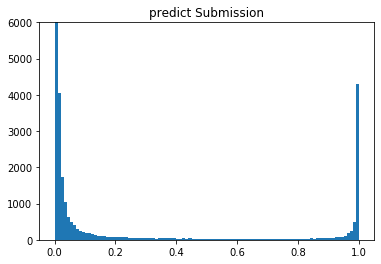

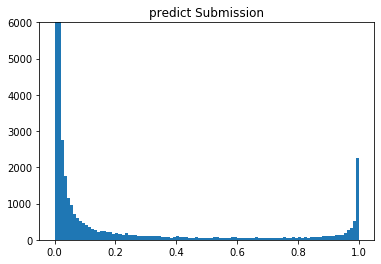

____________________________________________________________________________________________________
Fold 0


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-logloss:0.674362	val-logloss:0.674643
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.087953	val-logloss:0.099699
[200]	train-logloss:0.024345	val-logloss:0.04036
[300]	train-logloss:0.012521	val-logloss:0.031616
[400]	train-logloss:0.008762	val-logloss:0.030072
[500]	train-logloss:0.006932	val-logloss:0.029914
[600]	train-logloss:0.005829	val-logloss:0.029986
Stopping. Best iteration:
[476]	train-logloss:0.007269	val-logloss:0.02989



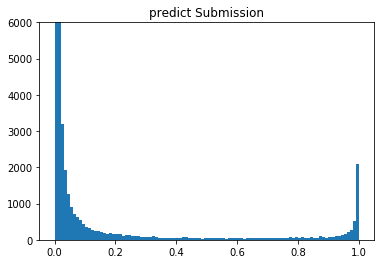

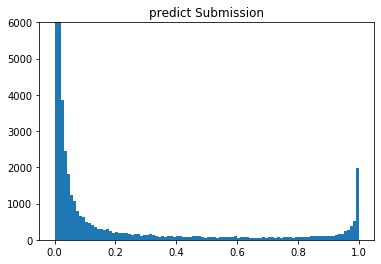

____________________________________________________________________________________________________
Fold 1
[0]	train-logloss:0.674429	val-logloss:0.674662
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.088733	val-logloss:0.098456
[200]	train-logloss:0.024763	val-logloss:0.037799
[300]	train-logloss:0.012745	val-logloss:0.028139
[400]	train-logloss:0.00891	val-logloss:0.025976
[500]	train-logloss:0.007005	val-logloss:0.025276
[600]	train-logloss:0.005886	val-logloss:0.02508
[700]	train-logloss:0.005125	val-logloss:0.02505
[800]	train-logloss:0.004575	val-logloss:0.025139
Stopping. Best iteration:
[693]	train-logloss:0.005174	val-logloss:0.025039



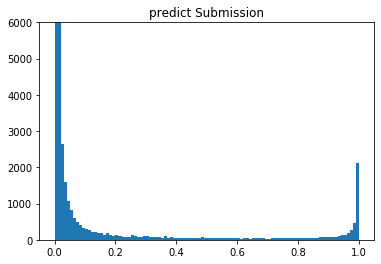

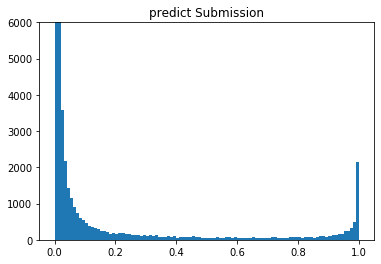

____________________________________________________________________________________________________
Fold 2
[0]	train-logloss:0.674313	val-logloss:0.674581
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.087868	val-logloss:0.099859
[200]	train-logloss:0.024156	val-logloss:0.040876
[300]	train-logloss:0.012243	val-logloss:0.032189
[400]	train-logloss:0.008471	val-logloss:0.030752
[500]	train-logloss:0.006678	val-logloss:0.030614
[600]	train-logloss:0.005598	val-logloss:0.030762
Stopping. Best iteration:
[493]	train-logloss:0.006776	val-logloss:0.030594



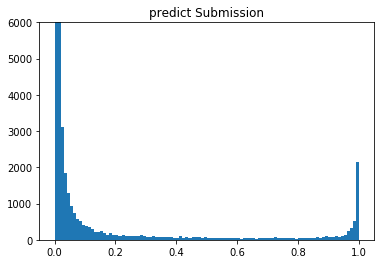

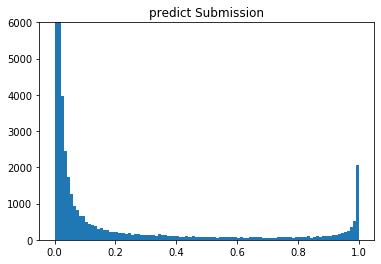

____________________________________________________________________________________________________
Fold 0


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-logloss:0.674362	val-logloss:0.674582
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.088447	val-logloss:0.09853
[200]	train-logloss:0.024722	val-logloss:0.038438
[300]	train-logloss:0.012753	val-logloss:0.029115
[400]	train-logloss:0.008937	val-logloss:0.027107
[500]	train-logloss:0.007066	val-logloss:0.026498
[600]	train-logloss:0.005956	val-logloss:0.026392
[700]	train-logloss:0.005186	val-logloss:0.026481
Stopping. Best iteration:
[585]	train-logloss:0.006094	val-logloss:0.026377



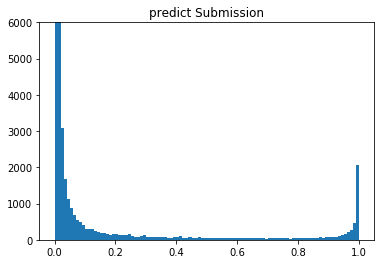

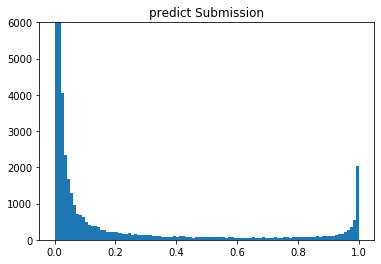

____________________________________________________________________________________________________
Fold 1
[0]	train-logloss:0.674349	val-logloss:0.674642
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.087903	val-logloss:0.100621
[200]	train-logloss:0.024112	val-logloss:0.041076
[300]	train-logloss:0.012289	val-logloss:0.032302
[400]	train-logloss:0.008586	val-logloss:0.030892
[500]	train-logloss:0.006762	val-logloss:0.03068
[600]	train-logloss:0.005671	val-logloss:0.030815
Stopping. Best iteration:
[492]	train-logloss:0.006862	val-logloss:0.030655



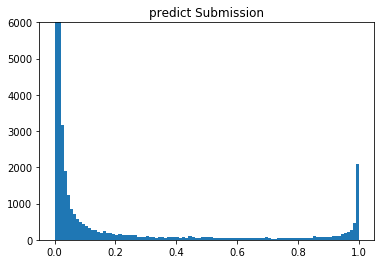

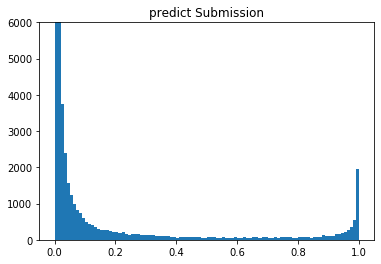

____________________________________________________________________________________________________
Fold 2
[0]	train-logloss:0.674344	val-logloss:0.674614
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.088301	val-logloss:0.098574
[200]	train-logloss:0.024404	val-logloss:0.038807
[300]	train-logloss:0.012466	val-logloss:0.029862
[400]	train-logloss:0.008664	val-logloss:0.028149
[500]	train-logloss:0.00685	val-logloss:0.027846
[600]	train-logloss:0.005741	val-logloss:0.027832
[700]	train-logloss:0.005003	val-logloss:0.028013
Stopping. Best iteration:
[550]	train-logloss:0.006238	val-logloss:0.027787



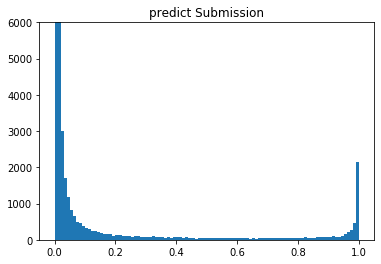

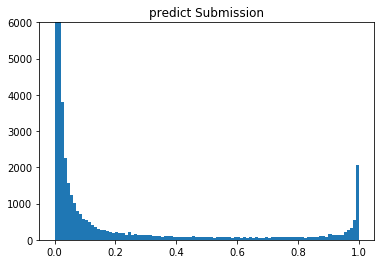

____________________________________________________________________________________________________
Fold 0


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-logloss:0.67441	val-logloss:0.674615
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.088497	val-logloss:0.096758
[200]	train-logloss:0.024492	val-logloss:0.035718
[300]	train-logloss:0.012502	val-logloss:0.025779
[400]	train-logloss:0.008668	val-logloss:0.02335
[500]	train-logloss:0.006818	val-logloss:0.022487
[600]	train-logloss:0.005684	val-logloss:0.0221
[700]	train-logloss:0.004939	val-logloss:0.021954
[800]	train-logloss:0.004413	val-logloss:0.021905
[900]	train-logloss:0.004023	val-logloss:0.021949
[1000]	train-logloss:0.003725	val-logloss:0.022031
Stopping. Best iteration:
[835]	train-logloss:0.004263	val-logloss:0.021896



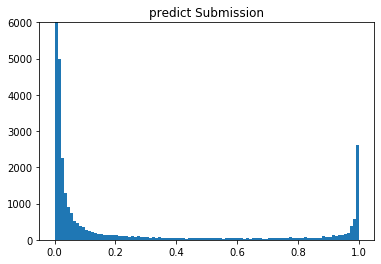

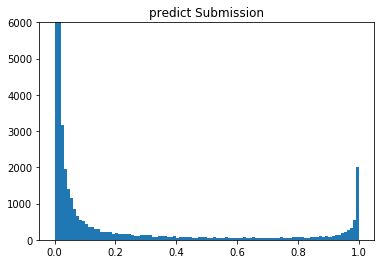

____________________________________________________________________________________________________
Fold 1
[0]	train-logloss:0.674362	val-logloss:0.674529
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.088465	val-logloss:0.096273
[200]	train-logloss:0.024538	val-logloss:0.035884
[300]	train-logloss:0.012539	val-logloss:0.026213
[400]	train-logloss:0.008692	val-logloss:0.023932
[500]	train-logloss:0.006842	val-logloss:0.02311
[600]	train-logloss:0.005726	val-logloss:0.02272
[700]	train-logloss:0.004971	val-logloss:0.022585
[800]	train-logloss:0.004429	val-logloss:0.022587
[900]	train-logloss:0.004034	val-logloss:0.022635
Stopping. Best iteration:
[739]	train-logloss:0.004736	val-logloss:0.022568



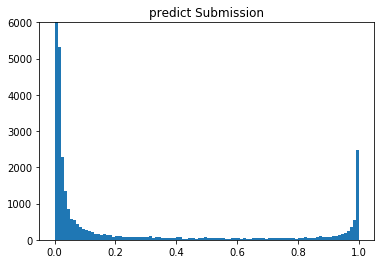

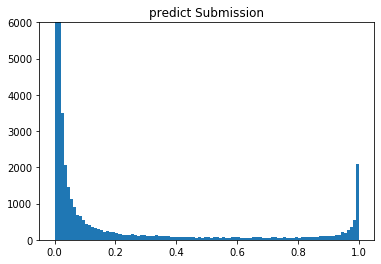

____________________________________________________________________________________________________
Fold 2
[0]	train-logloss:0.674374	val-logloss:0.674539
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.089069	val-logloss:0.096446
[200]	train-logloss:0.024931	val-logloss:0.035549
[300]	train-logloss:0.012832	val-logloss:0.025586
[400]	train-logloss:0.008922	val-logloss:0.023131
[500]	train-logloss:0.007003	val-logloss:0.022204
[600]	train-logloss:0.005851	val-logloss:0.021813
[700]	train-logloss:0.005074	val-logloss:0.021663
[800]	train-logloss:0.004537	val-logloss:0.021611
[900]	train-logloss:0.00412	val-logloss:0.021642
Stopping. Best iteration:
[790]	train-logloss:0.004579	val-logloss:0.021601



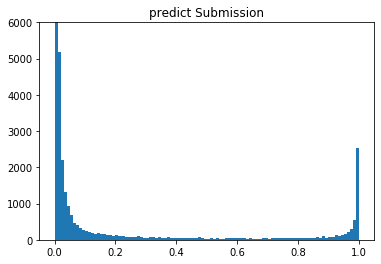

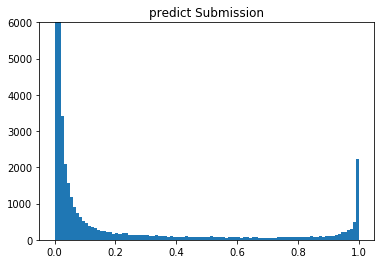

____________________________________________________________________________________________________
Fold 0


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-logloss:0.674464	val-logloss:0.674563
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.0894	val-logloss:0.093886
[200]	train-logloss:0.025185	val-logloss:0.031702
[300]	train-logloss:0.012916	val-logloss:0.020868
[400]	train-logloss:0.008878	val-logloss:0.017805
[500]	train-logloss:0.006877	val-logloss:0.016466
[600]	train-logloss:0.00567	val-logloss:0.015751
[700]	train-logloss:0.00484	val-logloss:0.015317
[800]	train-logloss:0.004262	val-logloss:0.015056
[900]	train-logloss:0.003839	val-logloss:0.014905
[1000]	train-logloss:0.003508	val-logloss:0.01482
[1100]	train-logloss:0.003252	val-logloss:0.014787
[1200]	train-logloss:0.003037	val-logloss:0.014764
[1300]	train-logloss:0.002868	val-logloss:0.01477
[1400]	train-logloss:0.002726	val-logloss:0.014786
Stopping. Best iteration:
[1234]	train-logloss:0.002978	val-logloss:0.01476



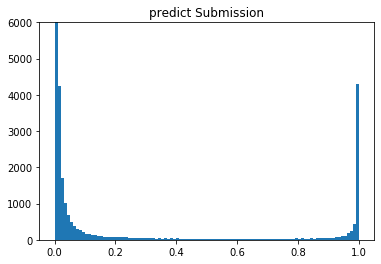

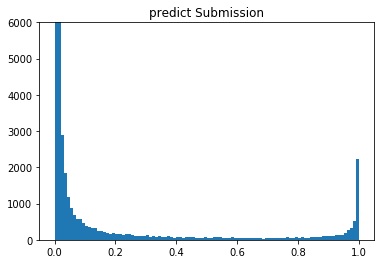

____________________________________________________________________________________________________
Fold 1
[0]	train-logloss:0.674423	val-logloss:0.674505
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.089692	val-logloss:0.093514
[200]	train-logloss:0.02541	val-logloss:0.031315
[300]	train-logloss:0.013109	val-logloss:0.020631
[400]	train-logloss:0.009068	val-logloss:0.017671
[500]	train-logloss:0.007093	val-logloss:0.016429
[600]	train-logloss:0.005864	val-logloss:0.01574
[700]	train-logloss:0.005048	val-logloss:0.01535
[800]	train-logloss:0.004468	val-logloss:0.015122
[900]	train-logloss:0.004039	val-logloss:0.014985
[1000]	train-logloss:0.003703	val-logloss:0.014909
[1100]	train-logloss:0.003452	val-logloss:0.014878
[1200]	train-logloss:0.003227	val-logloss:0.014835
[1300]	train-logloss:0.003055	val-logloss:0.014829
[1400]	train-logloss:0.002911	val-logloss:0.0

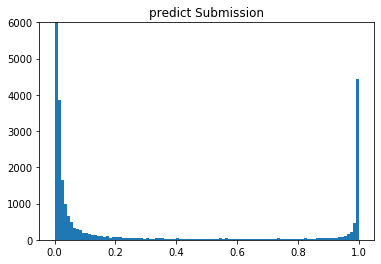

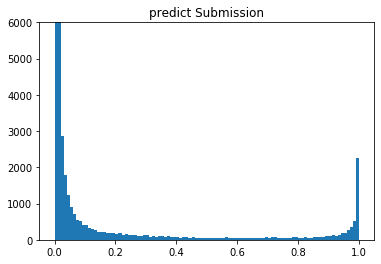

____________________________________________________________________________________________________
Fold 2
[0]	train-logloss:0.674406	val-logloss:0.674503
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.08949	val-logloss:0.093911
[200]	train-logloss:0.025189	val-logloss:0.031709
[300]	train-logloss:0.012925	val-logloss:0.02095
[400]	train-logloss:0.008907	val-logloss:0.017943
[500]	train-logloss:0.00692	val-logloss:0.016641
[600]	train-logloss:0.005701	val-logloss:0.015936
[700]	train-logloss:0.004884	val-logloss:0.015523
[800]	train-logloss:0.004321	val-logloss:0.015295
[900]	train-logloss:0.003886	val-logloss:0.015151
[1000]	train-logloss:0.003565	val-logloss:0.015071
[1100]	train-logloss:0.003317	val-logloss:0.015042
[1200]	train-logloss:0.003103	val-logloss:0.015012
[1300]	train-logloss:0.002934	val-logloss:0.01502
[1400]	train-logloss:0.002783	val-logloss:0.01

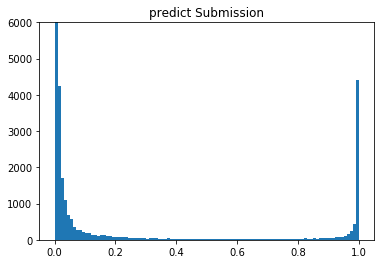

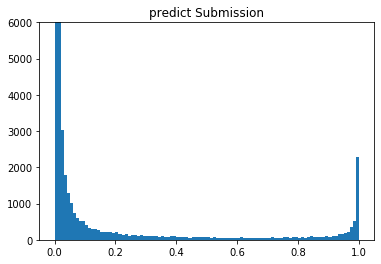

____________________________________________________________________________________________________
Fold 0


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-logloss:0.674362	val-logloss:0.674643
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.087953	val-logloss:0.099699
[200]	train-logloss:0.024345	val-logloss:0.04036
[300]	train-logloss:0.012521	val-logloss:0.031616
[400]	train-logloss:0.008762	val-logloss:0.030072
[500]	train-logloss:0.006932	val-logloss:0.029914
[600]	train-logloss:0.005829	val-logloss:0.029986
Stopping. Best iteration:
[476]	train-logloss:0.007269	val-logloss:0.02989



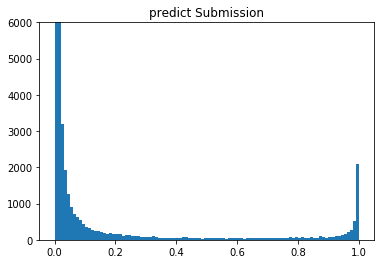

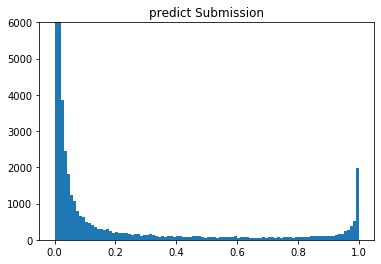

____________________________________________________________________________________________________
Fold 1
[0]	train-logloss:0.674429	val-logloss:0.674662
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.088733	val-logloss:0.098456
[200]	train-logloss:0.024763	val-logloss:0.037799
[300]	train-logloss:0.012745	val-logloss:0.028139
[400]	train-logloss:0.00891	val-logloss:0.025976
[500]	train-logloss:0.007005	val-logloss:0.025276
[600]	train-logloss:0.005886	val-logloss:0.02508
[700]	train-logloss:0.005125	val-logloss:0.02505
[800]	train-logloss:0.004575	val-logloss:0.025139
Stopping. Best iteration:
[693]	train-logloss:0.005174	val-logloss:0.025039



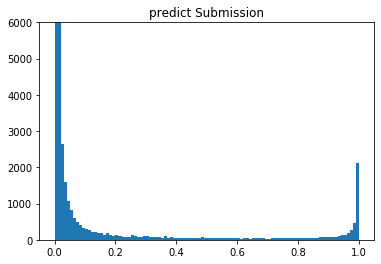

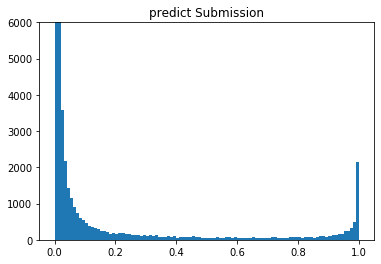

____________________________________________________________________________________________________
Fold 2
[0]	train-logloss:0.674313	val-logloss:0.674581
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.087868	val-logloss:0.099859
[200]	train-logloss:0.024156	val-logloss:0.040876
[300]	train-logloss:0.012243	val-logloss:0.032189
[400]	train-logloss:0.008471	val-logloss:0.030752
[500]	train-logloss:0.006678	val-logloss:0.030614
[600]	train-logloss:0.005598	val-logloss:0.030762
Stopping. Best iteration:
[493]	train-logloss:0.006776	val-logloss:0.030594



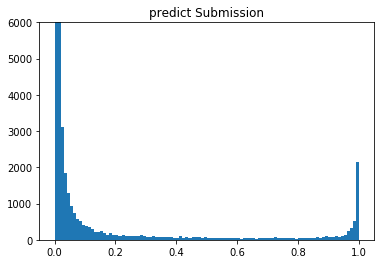

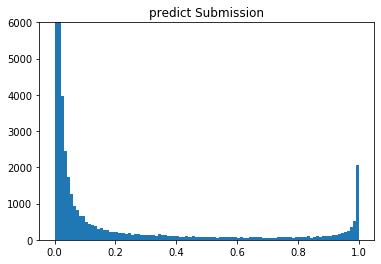

____________________________________________________________________________________________________
Fold 0


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-logloss:0.674362	val-logloss:0.674582
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.088447	val-logloss:0.09853
[200]	train-logloss:0.024722	val-logloss:0.038438
[300]	train-logloss:0.012753	val-logloss:0.029115
[400]	train-logloss:0.008937	val-logloss:0.027107
[500]	train-logloss:0.007066	val-logloss:0.026498
[600]	train-logloss:0.005956	val-logloss:0.026392
[700]	train-logloss:0.005186	val-logloss:0.026481
Stopping. Best iteration:
[585]	train-logloss:0.006094	val-logloss:0.026377



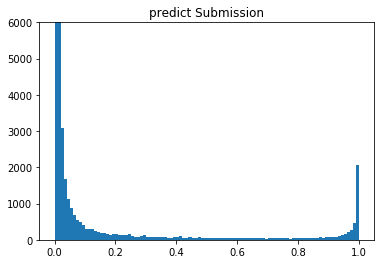

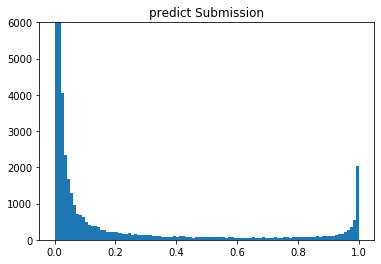

____________________________________________________________________________________________________
Fold 1
[0]	train-logloss:0.674349	val-logloss:0.674642
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.087903	val-logloss:0.100621
[200]	train-logloss:0.024112	val-logloss:0.041076
[300]	train-logloss:0.012289	val-logloss:0.032302
[400]	train-logloss:0.008586	val-logloss:0.030892
[500]	train-logloss:0.006762	val-logloss:0.03068
[600]	train-logloss:0.005671	val-logloss:0.030815
Stopping. Best iteration:
[492]	train-logloss:0.006862	val-logloss:0.030655



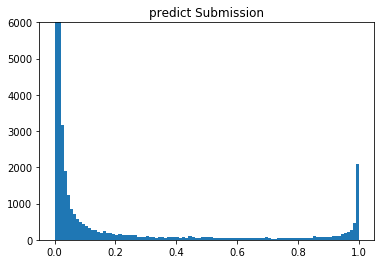

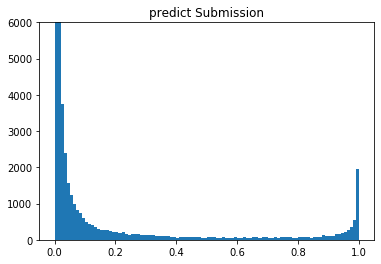

____________________________________________________________________________________________________
Fold 2
[0]	train-logloss:0.674344	val-logloss:0.674614
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.088301	val-logloss:0.098574
[200]	train-logloss:0.024404	val-logloss:0.038807
[300]	train-logloss:0.012466	val-logloss:0.029862
[400]	train-logloss:0.008664	val-logloss:0.028149
[500]	train-logloss:0.00685	val-logloss:0.027846
[600]	train-logloss:0.005741	val-logloss:0.027832
[700]	train-logloss:0.005003	val-logloss:0.028013
Stopping. Best iteration:
[550]	train-logloss:0.006238	val-logloss:0.027787



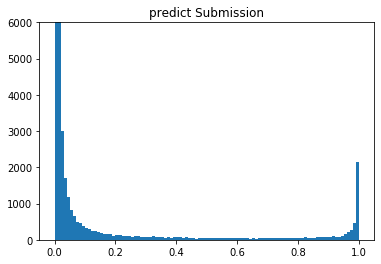

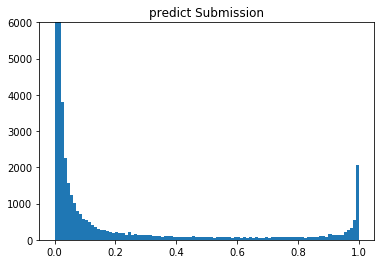

____________________________________________________________________________________________________
Fold 0


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-logloss:0.67441	val-logloss:0.674615
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.088497	val-logloss:0.096758
[200]	train-logloss:0.024492	val-logloss:0.035718
[300]	train-logloss:0.012502	val-logloss:0.025779
[400]	train-logloss:0.008668	val-logloss:0.02335
[500]	train-logloss:0.006818	val-logloss:0.022487
[600]	train-logloss:0.005684	val-logloss:0.0221
[700]	train-logloss:0.004939	val-logloss:0.021954
[800]	train-logloss:0.004413	val-logloss:0.021905
[900]	train-logloss:0.004023	val-logloss:0.021949
[1000]	train-logloss:0.003725	val-logloss:0.022031
Stopping. Best iteration:
[835]	train-logloss:0.004263	val-logloss:0.021896



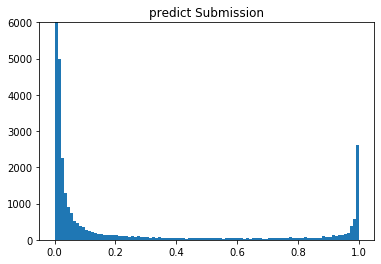

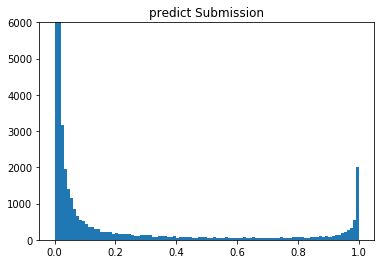

____________________________________________________________________________________________________
Fold 1
[0]	train-logloss:0.674362	val-logloss:0.674529
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.088465	val-logloss:0.096273
[200]	train-logloss:0.024538	val-logloss:0.035884
[300]	train-logloss:0.012539	val-logloss:0.026213
[400]	train-logloss:0.008692	val-logloss:0.023932
[500]	train-logloss:0.006842	val-logloss:0.02311
[600]	train-logloss:0.005726	val-logloss:0.02272
[700]	train-logloss:0.004971	val-logloss:0.022585
[800]	train-logloss:0.004429	val-logloss:0.022587
[900]	train-logloss:0.004034	val-logloss:0.022635
Stopping. Best iteration:
[739]	train-logloss:0.004736	val-logloss:0.022568



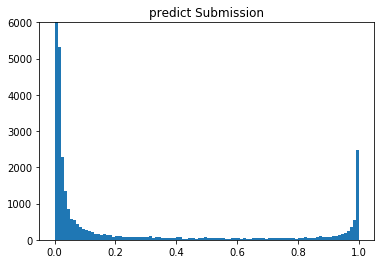

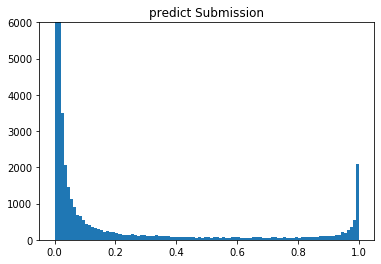

____________________________________________________________________________________________________
Fold 2
[0]	train-logloss:0.674374	val-logloss:0.674539
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.089069	val-logloss:0.096446
[200]	train-logloss:0.024931	val-logloss:0.035549
[300]	train-logloss:0.012832	val-logloss:0.025586
[400]	train-logloss:0.008922	val-logloss:0.023131
[500]	train-logloss:0.007003	val-logloss:0.022204
[600]	train-logloss:0.005851	val-logloss:0.021813
[700]	train-logloss:0.005074	val-logloss:0.021663
[800]	train-logloss:0.004537	val-logloss:0.021611
[900]	train-logloss:0.00412	val-logloss:0.021642
Stopping. Best iteration:
[790]	train-logloss:0.004579	val-logloss:0.021601



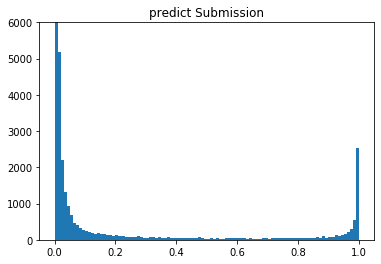

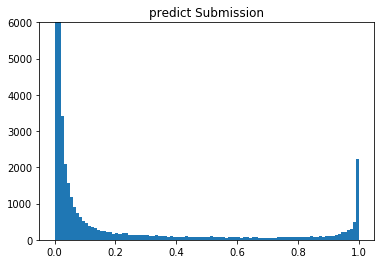

____________________________________________________________________________________________________
Fold 0


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-logloss:0.674412	val-logloss:0.674479
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.089551	val-logloss:0.09375
[200]	train-logloss:0.025253	val-logloss:0.031563
[300]	train-logloss:0.012936	val-logloss:0.020738
[400]	train-logloss:0.008913	val-logloss:0.017735
[500]	train-logloss:0.006902	val-logloss:0.016441
[600]	train-logloss:0.005706	val-logloss:0.01579
[700]	train-logloss:0.004889	val-logloss:0.015397
[800]	train-logloss:0.004326	val-logloss:0.015185
[900]	train-logloss:0.003901	val-logloss:0.015039
[1000]	train-logloss:0.003572	val-logloss:0.014956
[1100]	train-logloss:0.003319	val-logloss:0.014934
[1200]	train-logloss:0.003108	val-logloss:0.014941
[1300]	train-logloss:0.002942	val-logloss:0.014956
Stopping. Best iteration:
[1118]	train-logloss:0.003279	val-logloss:0.01493



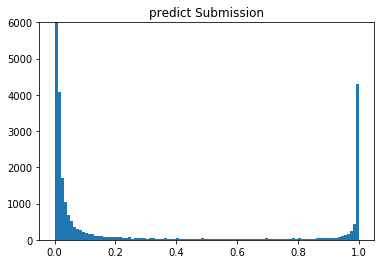

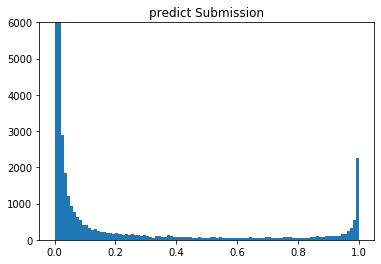

____________________________________________________________________________________________________
Fold 1
[0]	train-logloss:0.67439	val-logloss:0.674478
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.08938	val-logloss:0.093751
[200]	train-logloss:0.025205	val-logloss:0.031616
[300]	train-logloss:0.012946	val-logloss:0.020819
[400]	train-logloss:0.008971	val-logloss:0.01781
[500]	train-logloss:0.006998	val-logloss:0.016502
[600]	train-logloss:0.005801	val-logloss:0.01579
[700]	train-logloss:0.005008	val-logloss:0.0154
[800]	train-logloss:0.004443	val-logloss:0.015165
[900]	train-logloss:0.004008	val-logloss:0.015005
[1000]	train-logloss:0.003673	val-logloss:0.014916
[1100]	train-logloss:0.003419	val-logloss:0.01488
[1200]	train-logloss:0.003206	val-logloss:0.014854
[1300]	train-logloss:0.003033	val-logloss:0.014846
[1400]	train-logloss:0.002891	val-logloss:0.01486

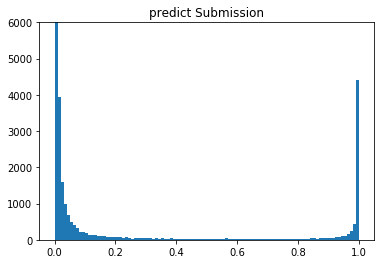

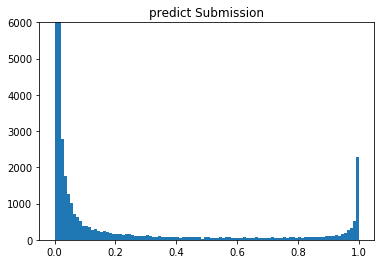

____________________________________________________________________________________________________
Fold 2
[0]	train-logloss:0.674394	val-logloss:0.674493
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.089593	val-logloss:0.093791
[200]	train-logloss:0.025318	val-logloss:0.031463
[300]	train-logloss:0.013033	val-logloss:0.020677
[400]	train-logloss:0.009006	val-logloss:0.017662
[500]	train-logloss:0.006992	val-logloss:0.016334
[600]	train-logloss:0.005759	val-logloss:0.015627
[700]	train-logloss:0.004951	val-logloss:0.015229
[800]	train-logloss:0.004371	val-logloss:0.014994
[900]	train-logloss:0.00394	val-logloss:0.014856
[1000]	train-logloss:0.003603	val-logloss:0.014767
[1100]	train-logloss:0.003349	val-logloss:0.014733
[1200]	train-logloss:0.003137	val-logloss:0.014708
[1300]	train-logloss:0.002968	val-logloss:0.014713
[1400]	train-logloss:0.002822	val-logloss:0

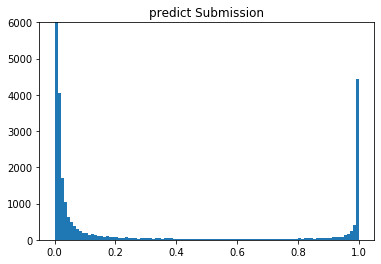

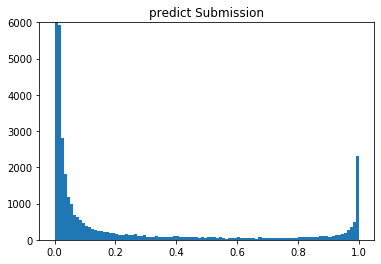

____________________________________________________________________________________________________
Fold 0


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-logloss:0.674362	val-logloss:0.674643
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.087953	val-logloss:0.099699
[200]	train-logloss:0.024345	val-logloss:0.04036
[300]	train-logloss:0.012521	val-logloss:0.031616
[400]	train-logloss:0.008762	val-logloss:0.030072
[500]	train-logloss:0.006932	val-logloss:0.029914
[600]	train-logloss:0.005829	val-logloss:0.029986
Stopping. Best iteration:
[476]	train-logloss:0.007269	val-logloss:0.02989



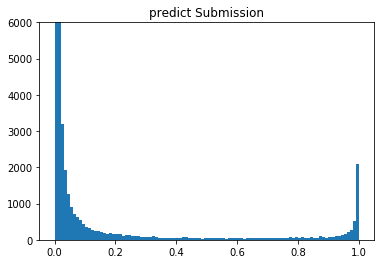

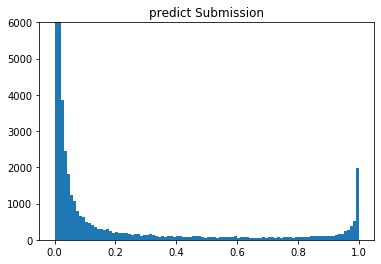

____________________________________________________________________________________________________
Fold 1
[0]	train-logloss:0.674429	val-logloss:0.674662
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.088733	val-logloss:0.098456
[200]	train-logloss:0.024763	val-logloss:0.037799
[300]	train-logloss:0.012745	val-logloss:0.028139
[400]	train-logloss:0.00891	val-logloss:0.025976
[500]	train-logloss:0.007005	val-logloss:0.025276
[600]	train-logloss:0.005886	val-logloss:0.02508
[700]	train-logloss:0.005125	val-logloss:0.02505
[800]	train-logloss:0.004575	val-logloss:0.025139
Stopping. Best iteration:
[693]	train-logloss:0.005174	val-logloss:0.025039



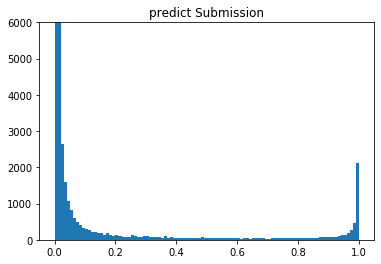

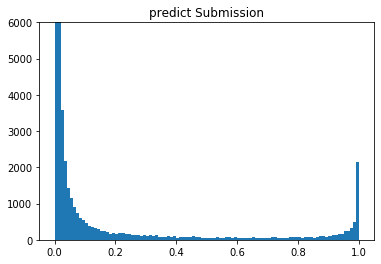

____________________________________________________________________________________________________
Fold 2
[0]	train-logloss:0.674313	val-logloss:0.674581
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.087868	val-logloss:0.099859
[200]	train-logloss:0.024156	val-logloss:0.040876
[300]	train-logloss:0.012243	val-logloss:0.032189
[400]	train-logloss:0.008471	val-logloss:0.030752
[500]	train-logloss:0.006678	val-logloss:0.030614
[600]	train-logloss:0.005598	val-logloss:0.030762
Stopping. Best iteration:
[493]	train-logloss:0.006776	val-logloss:0.030594



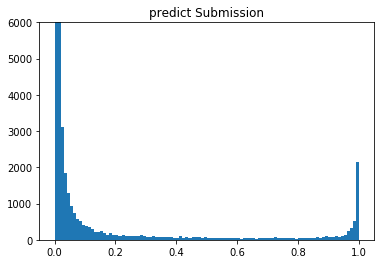

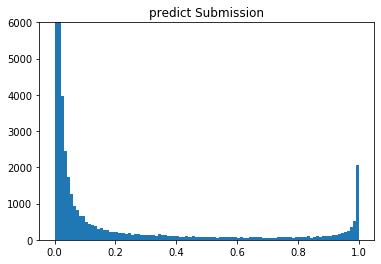

____________________________________________________________________________________________________
Fold 0


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-logloss:0.674362	val-logloss:0.674582
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.088447	val-logloss:0.09853
[200]	train-logloss:0.024722	val-logloss:0.038438
[300]	train-logloss:0.012753	val-logloss:0.029115
[400]	train-logloss:0.008937	val-logloss:0.027107
[500]	train-logloss:0.007066	val-logloss:0.026498
[600]	train-logloss:0.005956	val-logloss:0.026392
[700]	train-logloss:0.005186	val-logloss:0.026481
Stopping. Best iteration:
[585]	train-logloss:0.006094	val-logloss:0.026377



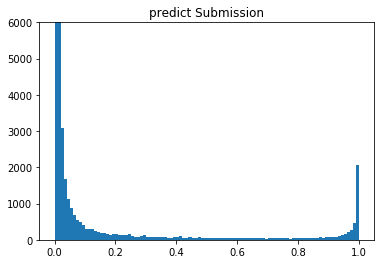

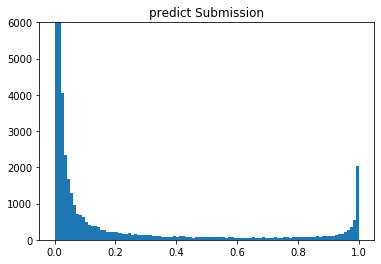

____________________________________________________________________________________________________
Fold 1
[0]	train-logloss:0.674349	val-logloss:0.674642
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.087903	val-logloss:0.100621
[200]	train-logloss:0.024112	val-logloss:0.041076
[300]	train-logloss:0.012289	val-logloss:0.032302
[400]	train-logloss:0.008586	val-logloss:0.030892
[500]	train-logloss:0.006762	val-logloss:0.03068
[600]	train-logloss:0.005671	val-logloss:0.030815
Stopping. Best iteration:
[492]	train-logloss:0.006862	val-logloss:0.030655



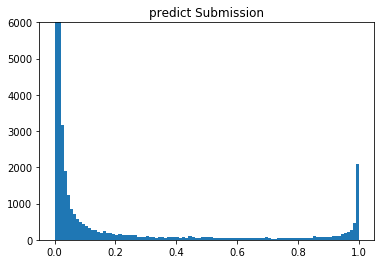

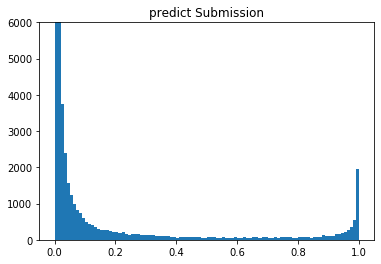

____________________________________________________________________________________________________
Fold 2
[0]	train-logloss:0.674344	val-logloss:0.674614
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.088301	val-logloss:0.098574
[200]	train-logloss:0.024404	val-logloss:0.038807
[300]	train-logloss:0.012466	val-logloss:0.029862
[400]	train-logloss:0.008664	val-logloss:0.028149
[500]	train-logloss:0.00685	val-logloss:0.027846
[600]	train-logloss:0.005741	val-logloss:0.027832
[700]	train-logloss:0.005003	val-logloss:0.028013
Stopping. Best iteration:
[550]	train-logloss:0.006238	val-logloss:0.027787



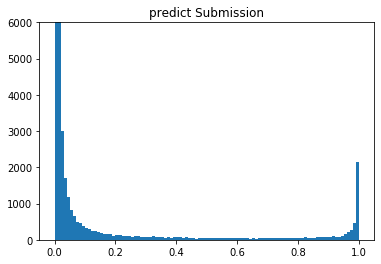

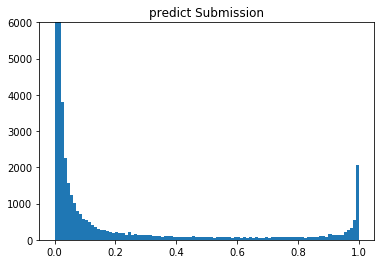

____________________________________________________________________________________________________
Fold 0


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-logloss:0.67441	val-logloss:0.674615
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.088497	val-logloss:0.096758
[200]	train-logloss:0.024492	val-logloss:0.035718
[300]	train-logloss:0.012502	val-logloss:0.025779
[400]	train-logloss:0.008668	val-logloss:0.02335
[500]	train-logloss:0.006818	val-logloss:0.022487
[600]	train-logloss:0.005684	val-logloss:0.0221
[700]	train-logloss:0.004939	val-logloss:0.021954
[800]	train-logloss:0.004413	val-logloss:0.021905
[900]	train-logloss:0.004023	val-logloss:0.021949
[1000]	train-logloss:0.003725	val-logloss:0.022031
Stopping. Best iteration:
[835]	train-logloss:0.004263	val-logloss:0.021896



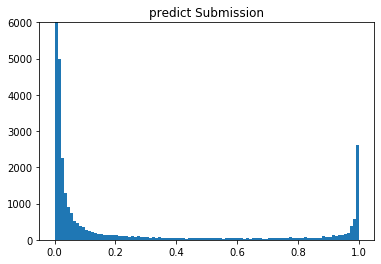

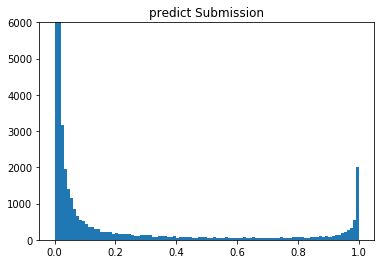

____________________________________________________________________________________________________
Fold 1
[0]	train-logloss:0.674362	val-logloss:0.674529
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.088465	val-logloss:0.096273
[200]	train-logloss:0.024538	val-logloss:0.035884
[300]	train-logloss:0.012539	val-logloss:0.026213
[400]	train-logloss:0.008692	val-logloss:0.023932
[500]	train-logloss:0.006842	val-logloss:0.02311
[600]	train-logloss:0.005726	val-logloss:0.02272
[700]	train-logloss:0.004971	val-logloss:0.022585
[800]	train-logloss:0.004429	val-logloss:0.022587
[900]	train-logloss:0.004034	val-logloss:0.022635
Stopping. Best iteration:
[739]	train-logloss:0.004736	val-logloss:0.022568



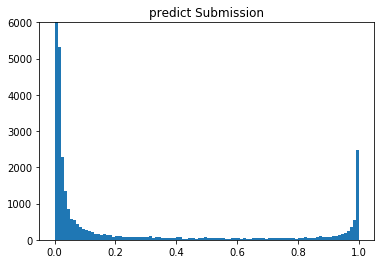

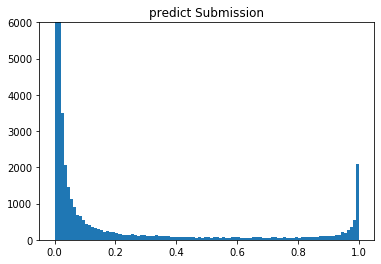

____________________________________________________________________________________________________
Fold 2
[0]	train-logloss:0.674374	val-logloss:0.674539
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.089069	val-logloss:0.096446
[200]	train-logloss:0.024931	val-logloss:0.035549
[300]	train-logloss:0.012832	val-logloss:0.025586
[400]	train-logloss:0.008922	val-logloss:0.023131
[500]	train-logloss:0.007003	val-logloss:0.022204
[600]	train-logloss:0.005851	val-logloss:0.021813
[700]	train-logloss:0.005074	val-logloss:0.021663
[800]	train-logloss:0.004537	val-logloss:0.021611
[900]	train-logloss:0.00412	val-logloss:0.021642
Stopping. Best iteration:
[790]	train-logloss:0.004579	val-logloss:0.021601



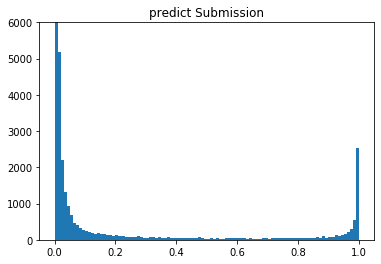

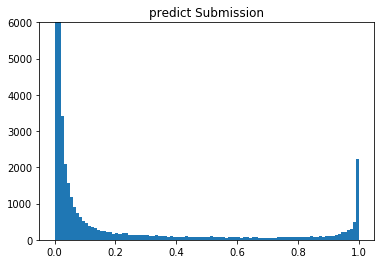

____________________________________________________________________________________________________
Fold 0


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-logloss:0.674435	val-logloss:0.674524
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.089592	val-logloss:0.093834
[200]	train-logloss:0.025349	val-logloss:0.031696
[300]	train-logloss:0.013039	val-logloss:0.020924
[400]	train-logloss:0.008994	val-logloss:0.017892
[500]	train-logloss:0.006987	val-logloss:0.016589
[600]	train-logloss:0.005773	val-logloss:0.015902
[700]	train-logloss:0.004965	val-logloss:0.015508
[800]	train-logloss:0.004387	val-logloss:0.015251
[900]	train-logloss:0.003957	val-logloss:0.015108
[1000]	train-logloss:0.003628	val-logloss:0.015031
[1100]	train-logloss:0.003373	val-logloss:0.014996
[1200]	train-logloss:0.003156	val-logloss:0.014962
[1300]	train-logloss:0.002986	val-logloss:0.014965
[1400]	train-logloss:0.002839	val-logloss:0.014973
Stopping. Best iteration:
[1218]	train-logloss:0.003124	val-logloss:0.014958



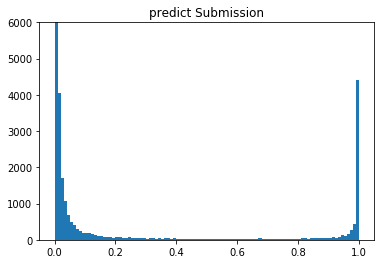

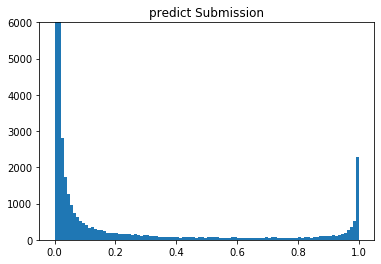

____________________________________________________________________________________________________
Fold 1
[0]	train-logloss:0.674398	val-logloss:0.67448
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.089321	val-logloss:0.093449
[200]	train-logloss:0.025116	val-logloss:0.031223
[300]	train-logloss:0.012915	val-logloss:0.020451
[400]	train-logloss:0.008903	val-logloss:0.017461
[500]	train-logloss:0.006915	val-logloss:0.016199
[600]	train-logloss:0.005729	val-logloss:0.015549
[700]	train-logloss:0.004926	val-logloss:0.015168
[800]	train-logloss:0.004361	val-logloss:0.014957
[900]	train-logloss:0.003943	val-logloss:0.014843
[1000]	train-logloss:0.003618	val-logloss:0.014779
[1100]	train-logloss:0.00336	val-logloss:0.01475
[1200]	train-logloss:0.003157	val-logloss:0.014746
[1300]	train-logloss:0.00299	val-logloss:0.014749
Stopping. Best iteration:
[1118]	train-logloss

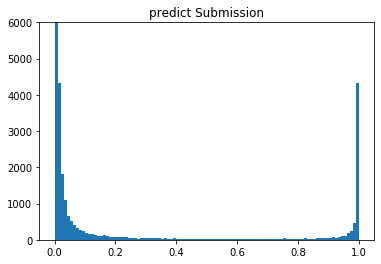

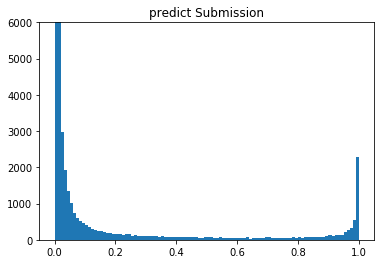

____________________________________________________________________________________________________
Fold 2
[0]	train-logloss:0.674385	val-logloss:0.674464
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.089505	val-logloss:0.093698
[200]	train-logloss:0.025312	val-logloss:0.031687
[300]	train-logloss:0.01298	val-logloss:0.020946
[400]	train-logloss:0.008942	val-logloss:0.017987
[500]	train-logloss:0.006899	val-logloss:0.016696
[600]	train-logloss:0.005659	val-logloss:0.016004
[700]	train-logloss:0.004856	val-logloss:0.015636
[800]	train-logloss:0.004281	val-logloss:0.01542
[900]	train-logloss:0.00385	val-logloss:0.015301
[1000]	train-logloss:0.003518	val-logloss:0.015225
[1100]	train-logloss:0.003256	val-logloss:0.015179
[1200]	train-logloss:0.00304	val-logloss:0.015167
[1300]	train-logloss:0.002876	val-logloss:0.015184
[1400]	train-logloss:0.002729	val-logloss:0.01

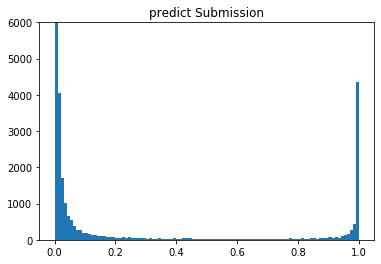

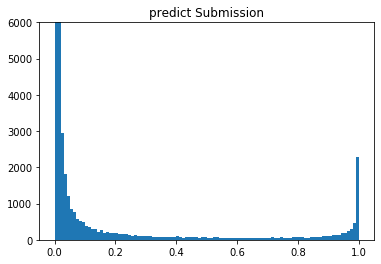

____________________________________________________________________________________________________
Fold 0


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-logloss:0.674362	val-logloss:0.674643
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.087953	val-logloss:0.099699
[200]	train-logloss:0.024345	val-logloss:0.04036
[300]	train-logloss:0.012521	val-logloss:0.031616
[400]	train-logloss:0.008762	val-logloss:0.030072
[500]	train-logloss:0.006932	val-logloss:0.029914
[600]	train-logloss:0.005829	val-logloss:0.029986
Stopping. Best iteration:
[476]	train-logloss:0.007269	val-logloss:0.02989



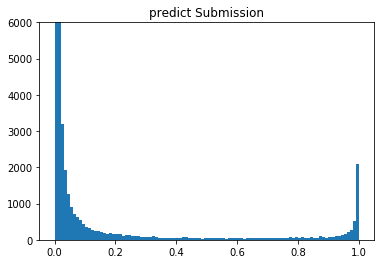

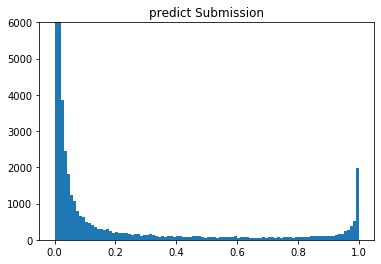

____________________________________________________________________________________________________
Fold 1
[0]	train-logloss:0.674429	val-logloss:0.674662
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.088733	val-logloss:0.098456
[200]	train-logloss:0.024763	val-logloss:0.037799
[300]	train-logloss:0.012745	val-logloss:0.028139
[400]	train-logloss:0.00891	val-logloss:0.025976
[500]	train-logloss:0.007005	val-logloss:0.025276
[600]	train-logloss:0.005886	val-logloss:0.02508
[700]	train-logloss:0.005125	val-logloss:0.02505
[800]	train-logloss:0.004575	val-logloss:0.025139
Stopping. Best iteration:
[693]	train-logloss:0.005174	val-logloss:0.025039



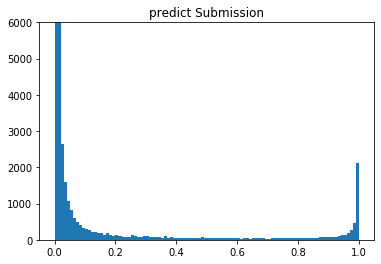

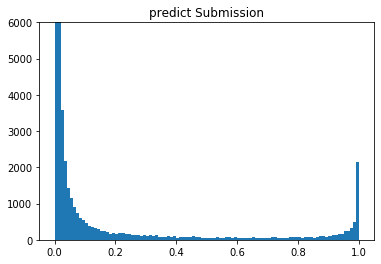

____________________________________________________________________________________________________
Fold 2
[0]	train-logloss:0.674313	val-logloss:0.674581
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.087868	val-logloss:0.099859
[200]	train-logloss:0.024156	val-logloss:0.040876
[300]	train-logloss:0.012243	val-logloss:0.032189
[400]	train-logloss:0.008471	val-logloss:0.030752
[500]	train-logloss:0.006678	val-logloss:0.030614
[600]	train-logloss:0.005598	val-logloss:0.030762
Stopping. Best iteration:
[493]	train-logloss:0.006776	val-logloss:0.030594



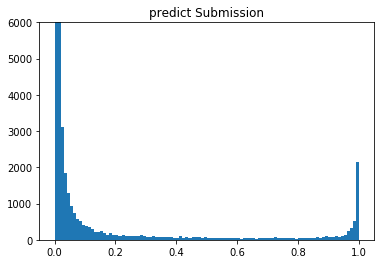

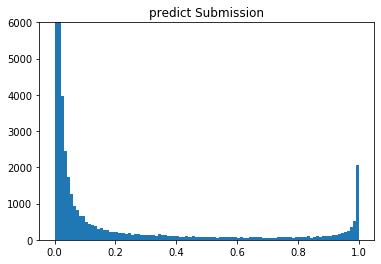

____________________________________________________________________________________________________
Fold 0


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-logloss:0.674362	val-logloss:0.674582
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.088447	val-logloss:0.09853
[200]	train-logloss:0.024722	val-logloss:0.038438
[300]	train-logloss:0.012753	val-logloss:0.029115
[400]	train-logloss:0.008937	val-logloss:0.027107
[500]	train-logloss:0.007066	val-logloss:0.026498
[600]	train-logloss:0.005956	val-logloss:0.026392
[700]	train-logloss:0.005186	val-logloss:0.026481
Stopping. Best iteration:
[585]	train-logloss:0.006094	val-logloss:0.026377



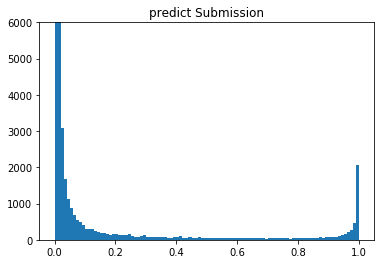

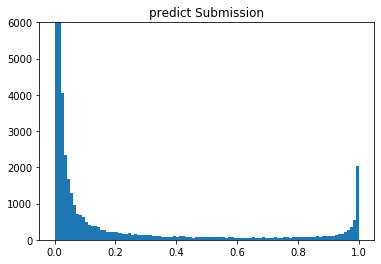

____________________________________________________________________________________________________
Fold 1
[0]	train-logloss:0.674349	val-logloss:0.674642
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.087903	val-logloss:0.100621
[200]	train-logloss:0.024112	val-logloss:0.041076
[300]	train-logloss:0.012289	val-logloss:0.032302
[400]	train-logloss:0.008586	val-logloss:0.030892
[500]	train-logloss:0.006762	val-logloss:0.03068
[600]	train-logloss:0.005671	val-logloss:0.030815
Stopping. Best iteration:
[492]	train-logloss:0.006862	val-logloss:0.030655



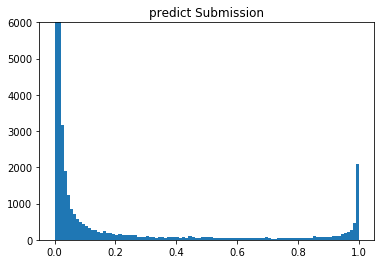

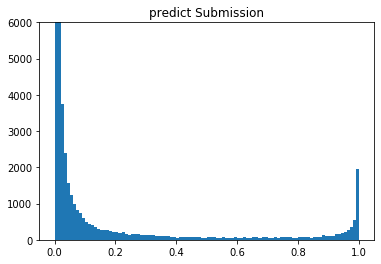

____________________________________________________________________________________________________
Fold 2
[0]	train-logloss:0.674344	val-logloss:0.674614
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.088301	val-logloss:0.098574
[200]	train-logloss:0.024404	val-logloss:0.038807
[300]	train-logloss:0.012466	val-logloss:0.029862
[400]	train-logloss:0.008664	val-logloss:0.028149
[500]	train-logloss:0.00685	val-logloss:0.027846
[600]	train-logloss:0.005741	val-logloss:0.027832
[700]	train-logloss:0.005003	val-logloss:0.028013
Stopping. Best iteration:
[550]	train-logloss:0.006238	val-logloss:0.027787



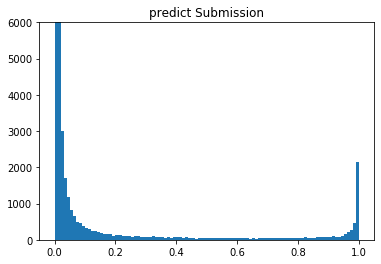

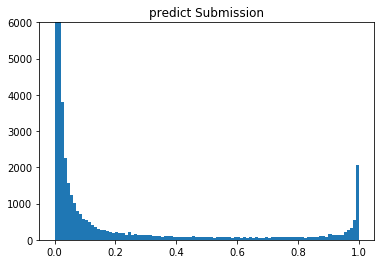

/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


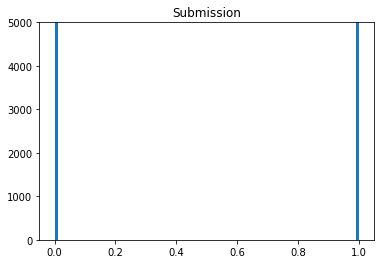

It cost 20663.940505 sec


In [40]:


model1_features =['acqic', 'conam', 'csmcu', 'ecfg', 'etymd',
       'mcc', 'mchno', 'scity', 'stocn',
       'stscd', 'loctm_hour','stocn_scity','mcc_mchno' ]
#remove_f = ['contp','iterm','hcefg']
temp = model1_features+cf+cf2+list(gf)+list(gf2)+list(gf_mcc)
model1_features= list(temp.copy())
model1_features.sort()
X_train = df[model1_features]
Y_train = df['fraud_ind']
X_test = df_test[model1_features]
#print(model1_features)Z
print(X_train.shape[1])
print(X_train.columns)

seed_num=[42,1121,915,1,43443,527418]
for seed_ in seed_num:
    train_set, test_set = get_stacking(X_train, Y_train, X_test,n_folds=3,which_model=2,SEED=seed_,group=1)
    train_sets.append(train_set)
    test_sets.append(test_set)
    train_set, test_set = get_stacking(X_train, Y_train, X_test,n_folds=3,which_model=2,SEED=seed_,group=2)
    train_sets.append(train_set)
    test_sets.append(test_set)
    train_set, test_set = get_stacking(X_train, Y_train, X_test,n_folds=3,which_model=2,SEED=seed_,group=3)
    train_sets.append(train_set)
    test_sets.append(test_set)
    train_set, test_set = get_stacking(X_train, Y_train, X_test,n_folds=3,which_model=2,SEED=seed_,group=4)
    train_sets.append(train_set)
    test_sets.append(test_set)


meta_train = np.concatenate([result_set.reshape(-1,1) for result_set in train_sets], axis=1)
meta_test = np.concatenate([y_test_set.reshape(-1,1) for y_test_set in test_sets], axis=1)
#使用logistic作為二級分類器
from sklearn.linear_model import LogisticRegression
dt_model = LogisticRegression()
dt_model.fit(meta_train, Y_train)
df_predict = dt_model.predict(meta_test)
plt.hist(df_predict,bins=100)
plt.ylim((0,5000))
plt.title('Submission')
plt.show()
tEnd = time.time()#計時結束
print ("It cost %f sec" % (tEnd - tStart))#會自動做近位

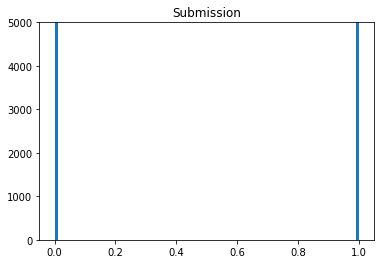

testdata = 421665
1.34% of testdata = 5650.0
fraud predict = 5921


In [41]:
plt.hist(df_predict,bins=100)
plt.ylim((0,5000))
plt.title('Submission')
plt.show()
sampleSubmission = pd.read_csv('submission_test_sample.csv')
sampleSubmission['fraud_ind'] = df_predict
sampleSubmission.to_csv('submission_test_STACK.csv',index = None)
print('testdata =',df_test['txkey'].count())
print('1.34% of testdata =',round(df_test['txkey'].count()*0.0134))
print('fraud predict =',sampleSubmission['fraud_ind'].value_counts()[1])
